In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pickle

In [2]:
# Constants for the environment
EMPTY = 0
WALL = 1
BOX = 2
STORAGE = 3
BOX_ON_STORAGE = 4
PLAYER = 5

In [3]:
# Sokoban environment initialization
def init():
    env = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
                    [1, 1, 1, 1, 1, 1, 2, 0, 1, 1],
                    [1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
                    [1, 1, 1, 1, 3, 0, 0, 0, 1, 1],
                    [1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
                    [1, 0, 0, 1, 0, 0, 3, 1, 1, 1],
                    [1, 0, 2, 2, 0, 0, 0, 1, 1, 1],
                    [1, 0, 0, 0, 0, 0, 3, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
    env[6, 2] = PLAYER  # Add the player at position (1,1)
    return env

In [16]:
# Load images corresponding to each constant
img_empty = mpimg.imread('fig_2.png')
img_wall = mpimg.imread('fig_1.png')
img_box = mpimg.imread('fig_4.png')
img_storage = mpimg.imread('fig_3.png')
img_box_on_storage = mpimg.imread('fig_5.png')
img_player = mpimg.imread('fig_6.png')

In [17]:
# Dictionary to map constants to their respective images
image_map = {
    EMPTY: img_empty,
    WALL: img_wall,
    BOX: img_box,
    STORAGE: img_storage,
    BOX_ON_STORAGE: img_box_on_storage,
    PLAYER: img_player
}

In [6]:
def display_env(state):
    # Determine the size of each image (assuming all images have the same size)
    img_height, img_width, _ = image_map[EMPTY].shape

    # Create an empty canvas to hold the full environment image
    full_img = np.zeros((state.shape[0] * img_height, state.shape[1] * img_width, 3))

    # Iterate over each element in the state and place the corresponding image
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            # Get the corresponding image for the current element
            img = image_map[state[i, j]]

            # Calculate the position in the full image canvas
            start_x = i * img_height
            start_y = j * img_width
            end_x = start_x + img_height
            end_y = start_y + img_width

            # Place the image in the correct location in the full image
            full_img[start_x:end_x, start_y:end_y, :] = img

    # Display the full environment image
    plt.imshow(full_img)
    plt.axis('off')  # Turn off the axis
    plt.show()


In [7]:
# Check if all boxes are in storage (goal state)
def is_goal(state):
    return not np.any(state == BOX)

In [8]:
# Enhanced deadlock detection function
def is_deadlock(state):
    # Check for more sophisticated deadlock detection
    for i in range(1, state.shape[0] - 1):
        for j in range(1, state.shape[1] - 1):
            if state[i, j] == BOX:
                if (state[i-1, j] == WALL or state[i+1, j] == WALL) and \
                   (state[i, j-1] == WALL or state[i, j+1] == WALL):
                    return True
                # Detect if box is surrounded by walls and other boxes
                if state[i-1, j] == BOX and state[i, j-1] == BOX:
                    return True
    return False

In [9]:
def flatten_state(state):
    return tuple(state.flatten())

In [10]:
# Generate the next state and return a reward for pushing a box
def get_child(state, from_x, from_y, to_x, to_y):
    new_state = np.copy(state)
    reward = -1  # Default movement reward

    if new_state[to_x, to_y] == WALL:
        reward = -1
        return state, reward  # Invalid move, return original state with penalty
    if new_state[to_x, to_y] == BOX_ON_STORAGE:
        reward = -1
        return state, reward
    if new_state[to_x, to_y] == EMPTY:
        new_state[from_x, from_y], new_state[to_x, to_y] = EMPTY, PLAYER
        reward = -1  # Normal movement
    elif new_state[to_x, to_y] == BOX:
        push_x, push_y = to_x + (to_x - from_x), to_y + (to_y - from_y)
        if new_state[push_x, push_y] in [EMPTY, STORAGE]:
            # Player successfully pushes the box
            new_state[from_x, from_y], new_state[to_x, to_y] = EMPTY, PLAYER
            if new_state[push_x, push_y] == STORAGE:
                new_state[push_x, push_y] = BOX_ON_STORAGE
                reward = 50  # Reward for placing box in storage
            else:
                new_state[push_x, push_y] = BOX
                reward = 0  # Reward for moving the box
        if new_state[push_x, push_y] == WALL:
            reward = -5
            return state,reward
    return new_state, reward


In [11]:
# Get all possible actions of the player and corresponding rewards
def generate_children(state, previous_state):
    x, y = np.where(state == PLAYER)
    if len(x) == 0 or len(y) == 0:
        return []  # No valid player position found
    x, y = x[0], y[0]
    moves = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]  # Down, Up, Right, Left
    children = []

    for mx, my in moves:
        child_state, reward = get_child(state, x, y, mx, my)
        if mx < 0 or mx >= state.shape[0] or my < 0 or my >= state.shape[1]:
            continue  # Ignore out-of-bound moves

        if reward == 0:  # No box was pushed
            reward = -1  # Small penalty for just moving around


        # Penalize if the agent revisits the previous state
        if np.array_equal(child_state, previous_state):
            reward -= 5  # Heavy penalty for backtracking

        # If the agent does nothing (stays in the same position), add a penalty
        if np.array_equal(state, child_state):
            reward -= 3  # Penalty for standing still

        if is_deadlock(child_state):
            reward -= 10


        children.append((child_state, reward))

    return children

In [ ]:
def plot_learning(rewards, steps):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Episode Rewards Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1, 2, 2)
    plt.plot(steps)
    plt.title('Steps to Reach Goal Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Steps')

    plt.show()

In [ ]:
# Save the model to a file
def save_model(Q, filename):
    with open(filename, 'wb') as f:
        pickle.dump(Q, f)
    print(f"Model saved to {filename}")

In [12]:
# Load the model from a file
def load_model(filename):
    with open(filename, 'rb') as f:
        Q = pickle.load(f)
    print(f"Model loaded from {filename}")
    return Q

In [ ]:
def plot_pr(model, rewards_pr1,rewards_pr2, rewards_pr3 , steps_pr1, steps_pr2, steps_pr3):
    # Create a figure and two subplots
    fig, axs = plt.subplots(2, 1, figsize=(6, 5))

    # Plot reward maps
    axs[0].plot(rewards_pr1, label='Reward Parameter 3')
    axs[0].plot(rewards_pr2, label='Reward Parameter 2')
    axs[0].plot(rewards_pr3, label='Reward Parameter 1')

    # Add labels, title, legend for reward maps
    axs[0].set_title('Rewards'+' '+model)
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Rewards')
    axs[0].legend()

    # Plot step maps
    axs[1].plot(steps_pr1, label='Step Parameter 3')
    axs[1].plot(steps_pr2, label='Step Parameter 2')
    axs[1].plot(steps_pr3, label='Step Parameter 1')

    # Add labels, title, legend for step maps
    axs[1].set_title('Steps'+' '+model)
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Steps')
    axs[1].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_map(map, rewards_m1,rewards_m2, rewards_m3 , steps_m1, steps_m2, steps_m3):
    # Create a figure and two subplots
    fig, axs = plt.subplots(2, 1, figsize=(6, 5))

    # Plot reward maps
    axs[0].plot(rewards_m1, label='Reward MC')
    axs[0].plot(rewards_m2, label='Reward SARSA')
    axs[0].plot(rewards_m3, label='Reward Q-learning')

    # Add labels, title, legend for reward maps
    axs[0].set_title('Reward'+' '+map)
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Rewards')
    axs[0].legend()

    # Plot step maps
    axs[1].plot(steps_m1, label='Step MC')
    axs[1].plot(steps_m2, label='Step SARSA')
    axs[1].plot(steps_m3, label='Step Q-learning')

    # Add labels, title, legend for step maps
    axs[1].set_title('Step'+' '+map)
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Steps')
    axs[1].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

**Monte-Carlo**




In [ ]:
# Monte-Carlo algorithm with improvements
def monte_carlo(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes,
                max_steps):
    # Initialize Q-table as a dictionary
    Q = {}
    episode_rewards = []  # To store the total reward for each episode
    steps_to_goal = []  # To store the number of steps to reach the goal in each episode

    for episode in range(episodes):
        # Initialize the environment and state
        state = init()
        previous_state = None
        state_key = flatten_state(state)

        # Initialize episode memory
        episode_memory = []  # To store (state, action, reward) for the episode
        total_reward = 0
        step = 0

        for step in range(max_steps):
            # Initialize Q-values for the state if it's not already in Q-table
            if state_key not in Q:
                Q[state_key] = [0] * 4  # Four possible actions (down, up, right, left)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, 3)  # Explore: random action
            else:
                action = np.argmax(Q[state_key])  # Exploit: choose best action

            # Generate the next state based on action
            children = generate_children(state, previous_state)

            if len(children) == 0:
                break  # No valid children, end the episode

            next_state, reward = children[action]
            total_reward += reward
            next_state_key = flatten_state(next_state)

            # Save state, action, and reward to memory
            episode_memory.append((state_key, action, reward))

            # Update state and previous state
            previous_state = state
            state = next_state
            state_key = next_state_key

            if is_goal(state):
                break  # Episode ends if the goal is reached

        # Update Q-values based on the episode's experience (Monte Carlo update)
        G = 0  # Initialize the return
        for state_key, action, reward in reversed(episode_memory):
            G = gamma * G + reward  # Accumulate discounted reward

            # Update Q-value using the first-visit method
            Q[state_key][action] = Q[state_key][action] + alpha * (G - Q[state_key][action])

        # Decay epsilon after each episode
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Track rewards and steps for performance analysis
        episode_rewards.append(total_reward)
        steps_to_goal.append(step)

        # Print every 100 episodes for monitoring
        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}, Steps: {step}")

    return Q, episode_rewards, steps_to_goal

Episode 0: Total Reward: -3067, Steps: 499
Episode 100: Total Reward: -1643, Steps: 499
Episode 200: Total Reward: -1621, Steps: 499
Episode 300: Total Reward: -1430, Steps: 499
Episode 400: Total Reward: -3092, Steps: 499
Episode 500: Total Reward: -3118, Steps: 499
Episode 600: Total Reward: -1744, Steps: 499
Episode 700: Total Reward: -1647, Steps: 499
Episode 800: Total Reward: -1528, Steps: 499
Episode 900: Total Reward: -1073, Steps: 499
Episode 1000: Total Reward: -1415, Steps: 499
Episode 1100: Total Reward: -804, Steps: 499
Episode 1200: Total Reward: -674, Steps: 44
Episode 1300: Total Reward: -1495, Steps: 499
Episode 1400: Total Reward: -2455, Steps: 499
Episode 1500: Total Reward: -924, Steps: 499
Episode 1600: Total Reward: -869, Steps: 499
Episode 1700: Total Reward: -1592, Steps: 499
Episode 1800: Total Reward: -133, Steps: 59
Episode 1900: Total Reward: -895, Steps: 499
Episode 2000: Total Reward: -188, Steps: 145
Episode 2100: Total Reward: -124, Steps: 124
Episode 22

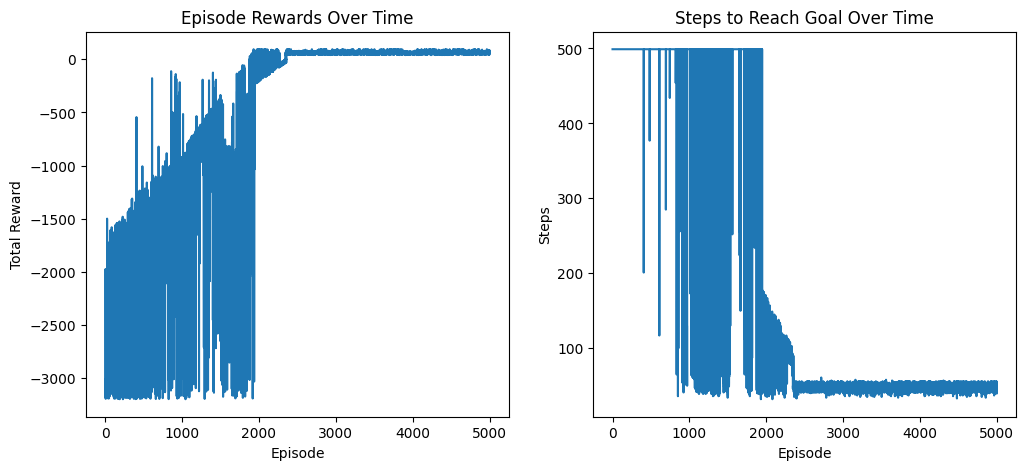

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_mc_model_pr1.pkl'

    # Train the agent using Monte-Carlo
    Q, mc_rewards_pr1, mc_steps_pr1 = monte_carlo(env, alpha=0.1, gamma=0.85, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.3, episodes=5000,max_steps=500)

    # Save the trained model
    save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(mc_rewards_pr1, mc_steps_pr1)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break

Model loaded from map2_mc_model_pr1.pkl
Initial State:


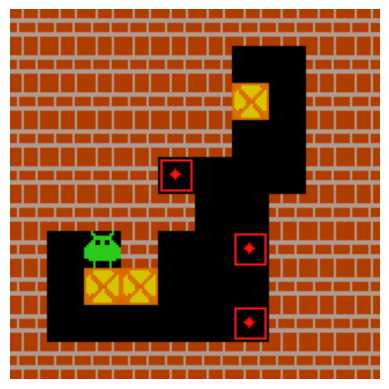

Agent Moved:


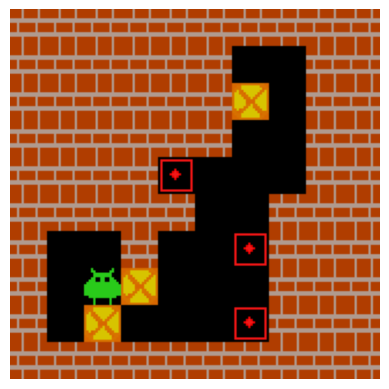

Agent Moved:


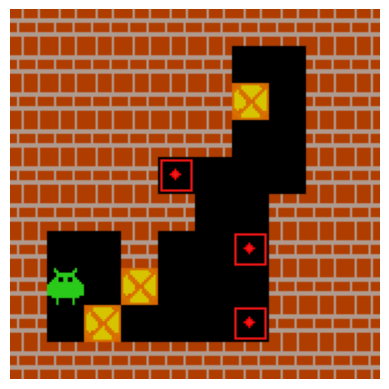

Agent Moved:


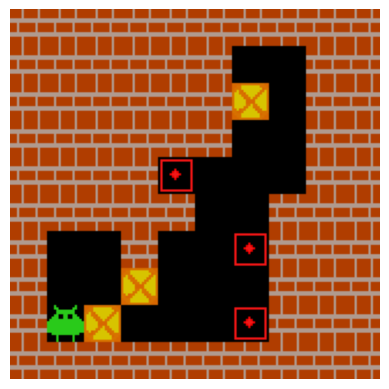

Agent Moved:


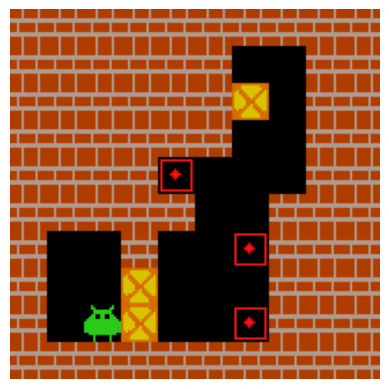

Agent Moved:


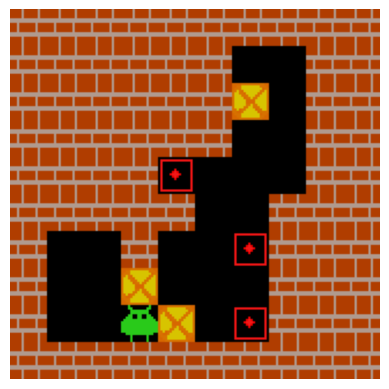

Agent Moved:


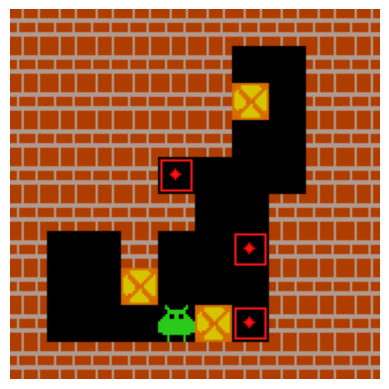

Agent Moved:


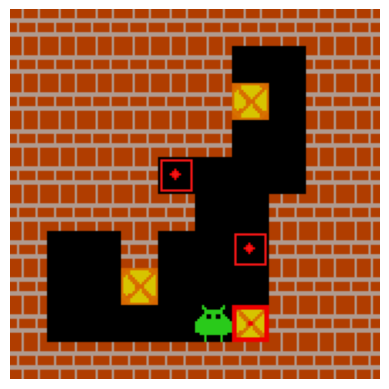

Agent Moved:


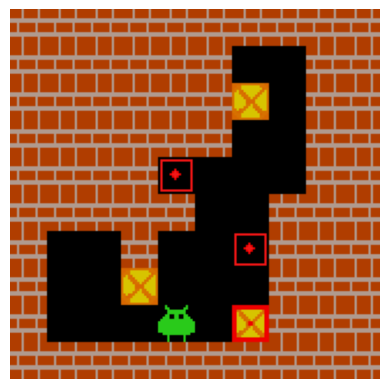

Agent Moved:


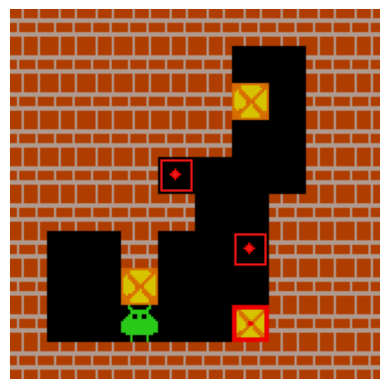

Agent Moved:


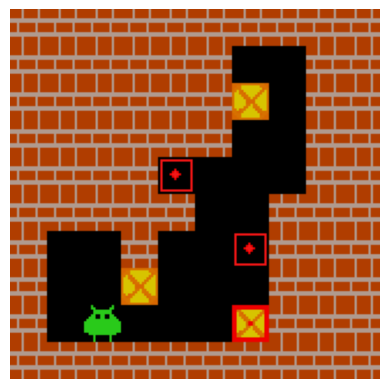

Agent Moved:


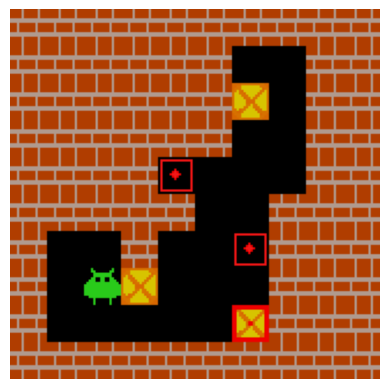

Agent Moved:


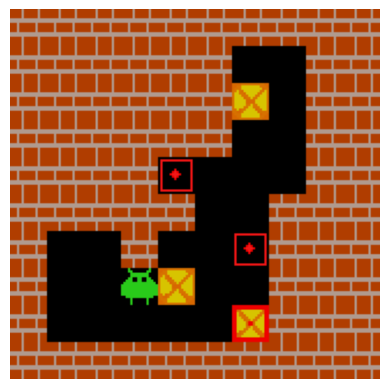

Agent Moved:


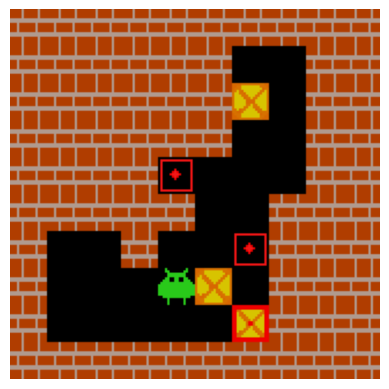

Agent Moved:


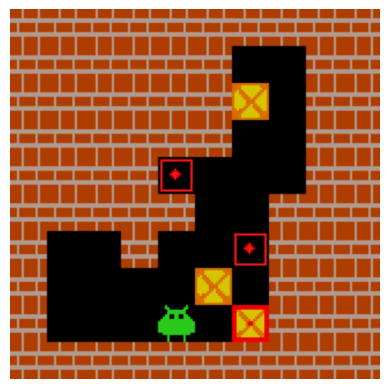

Agent Moved:


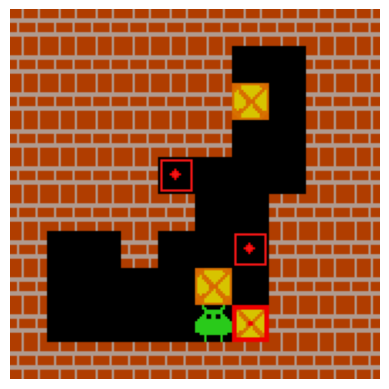

Agent Moved:


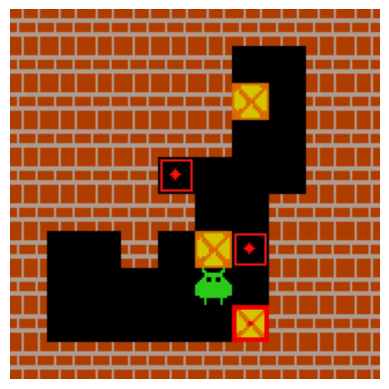

Agent Moved:


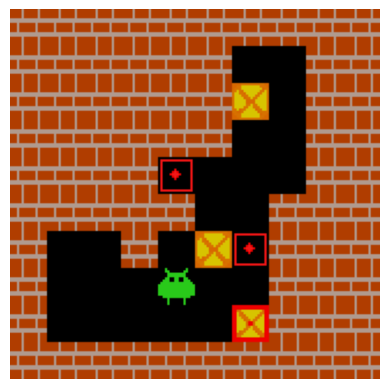

Agent Moved:


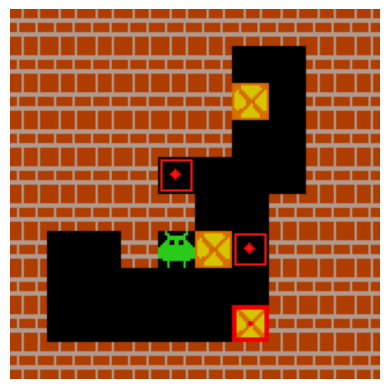

Agent Moved:


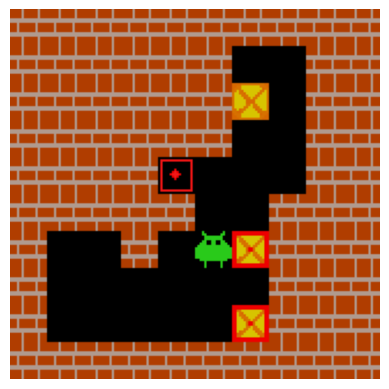

Agent Moved:


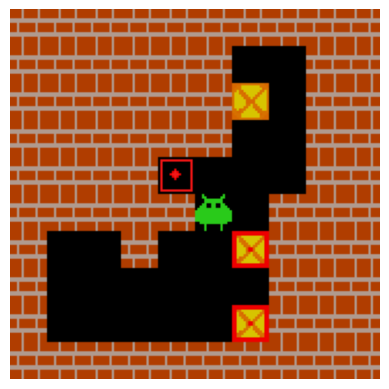

Agent Moved:


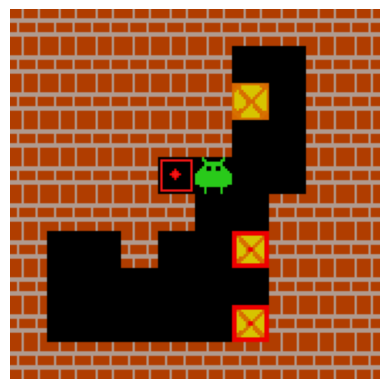

Agent Moved:


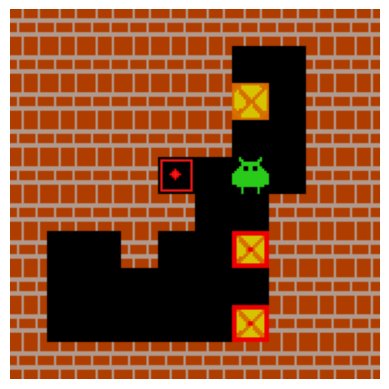

Agent Moved:


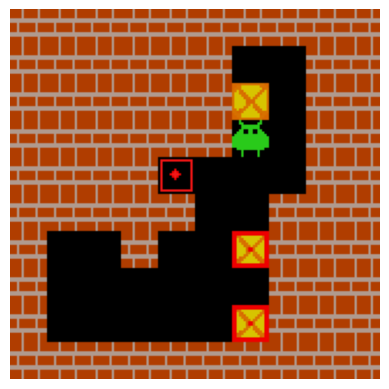

Agent Moved:


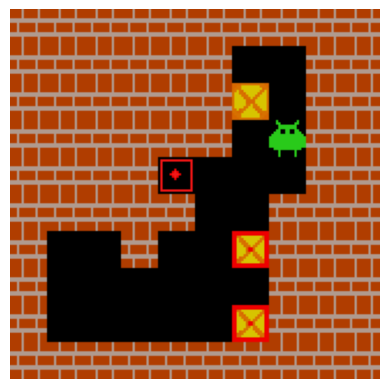

Agent Moved:


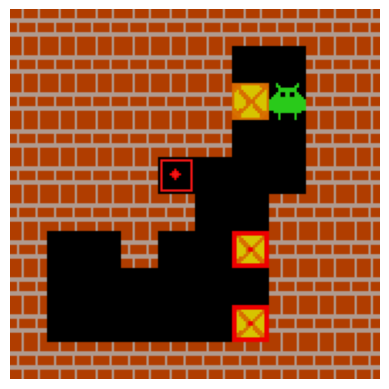

Agent Moved:


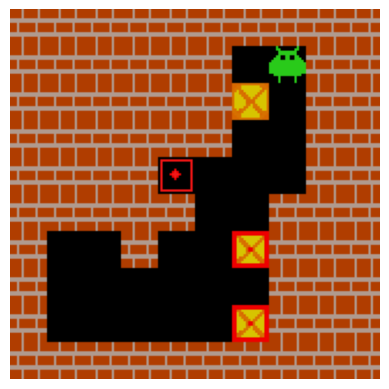

Agent Moved:


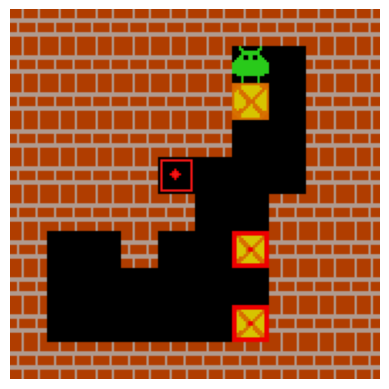

Agent Moved:


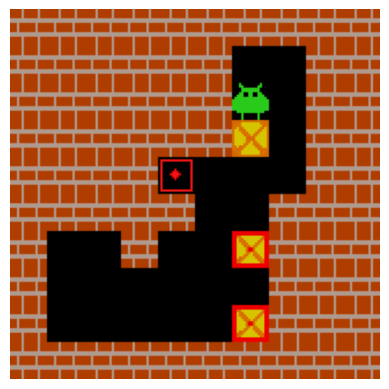

Agent Moved:


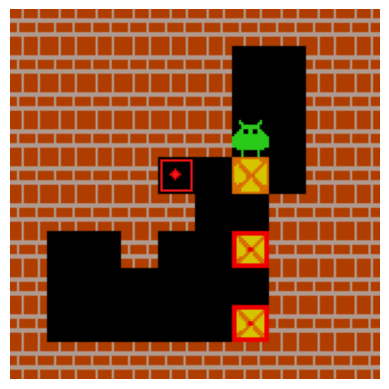

Agent Moved:


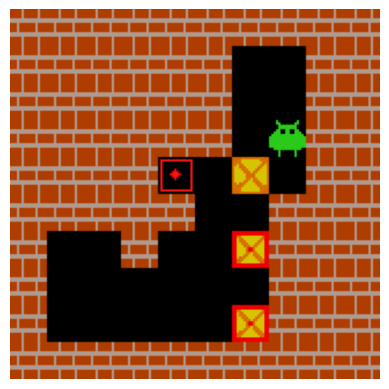

Agent Moved:


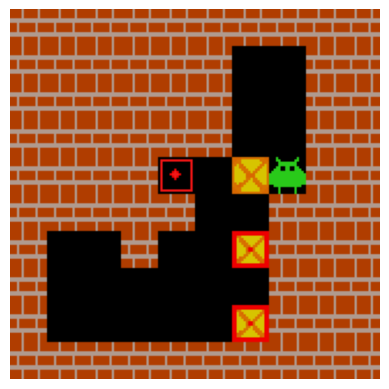

Agent Moved:


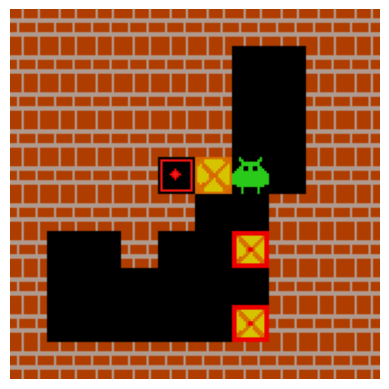

Agent Moved:


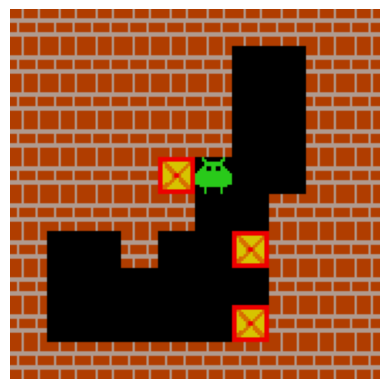

Goal Reached!


In [18]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_mc_model_pr1.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


Episode 0: Total Reward: -3149, Steps: 499
Episode 100: Total Reward: -3095, Steps: 499
Episode 200: Total Reward: -3112, Steps: 499
Episode 300: Total Reward: -3184, Steps: 499
Episode 400: Total Reward: -3166, Steps: 499
Episode 500: Total Reward: -1798, Steps: 499
Episode 600: Total Reward: -1208, Steps: 499
Episode 700: Total Reward: -1203, Steps: 499
Episode 800: Total Reward: -1388, Steps: 499
Episode 900: Total Reward: -970, Steps: 44
Episode 1000: Total Reward: -3008, Steps: 499
Episode 1100: Total Reward: -212, Steps: 100
Episode 1200: Total Reward: -670, Steps: 44
Episode 1300: Total Reward: -883, Steps: 499
Episode 1400: Total Reward: -448, Steps: 38
Episode 1500: Total Reward: -864, Steps: 499
Episode 1600: Total Reward: -1986, Steps: 499
Episode 1700: Total Reward: -112, Steps: 83
Episode 1800: Total Reward: -963, Steps: 499
Episode 1900: Total Reward: -937, Steps: 499
Episode 2000: Total Reward: 88, Steps: 41
Episode 2100: Total Reward: -266, Steps: 145
Episode 2200: Tota

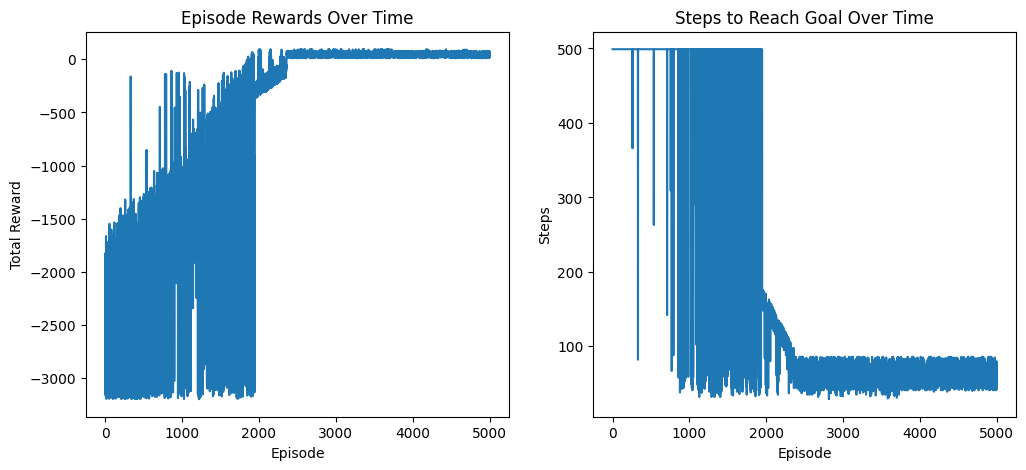

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_mc_model_pr2.pkl'

    # Train the agent using Monte-Carlo
    Q, mc_rewards_pr2, mc_steps_pr2 = monte_carlo(env, alpha=0.2, gamma=0.85, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.3, episodes=5000,
                max_steps=500)

    # Save the trained model
    save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(mc_rewards_pr2, mc_steps_pr2)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break

Model loaded from map2_mc_model_pr2.pkl
Initial State:


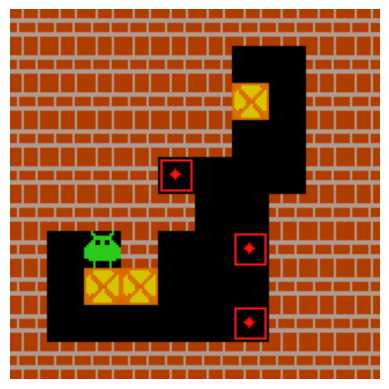

Agent Moved:


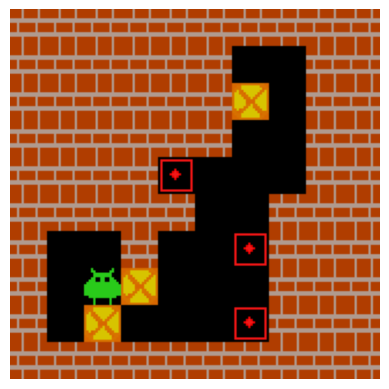

Agent Moved:


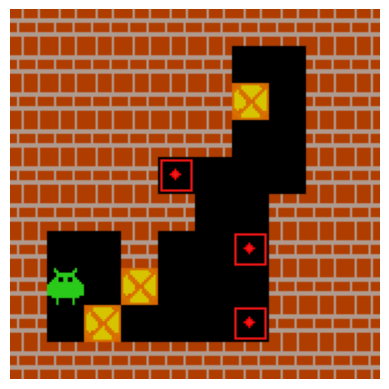

Agent Moved:


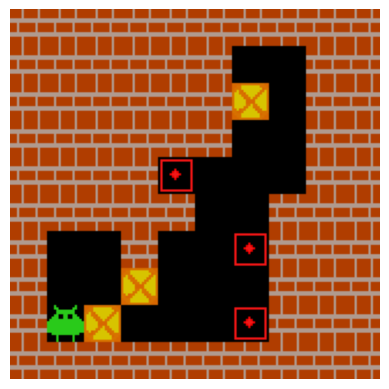

Agent Moved:


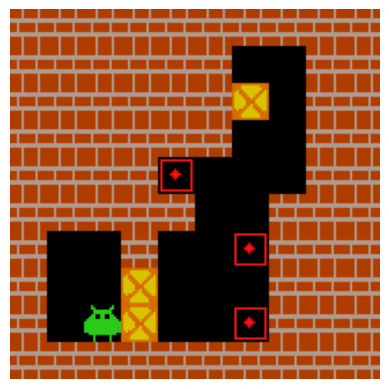

Agent Moved:


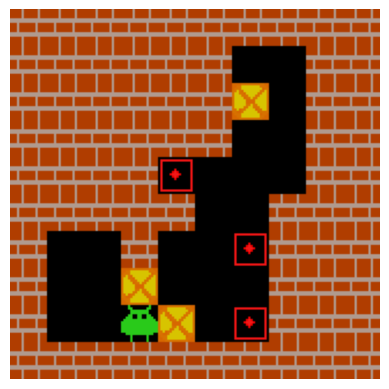

Agent Moved:


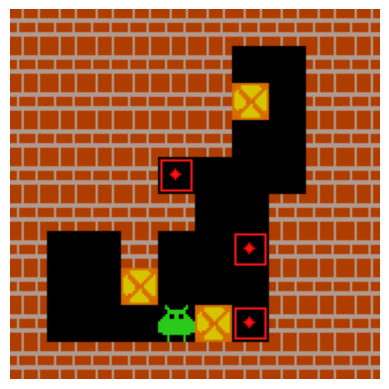

Agent Moved:


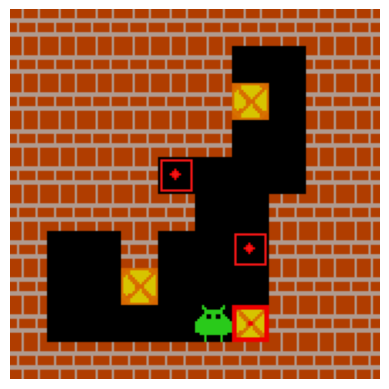

Agent Moved:


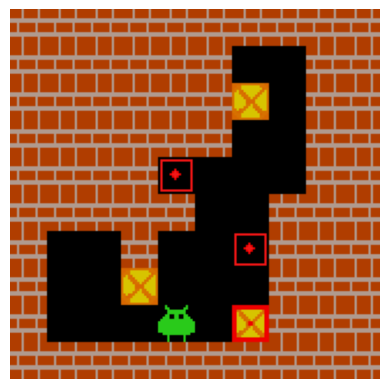

Agent Moved:


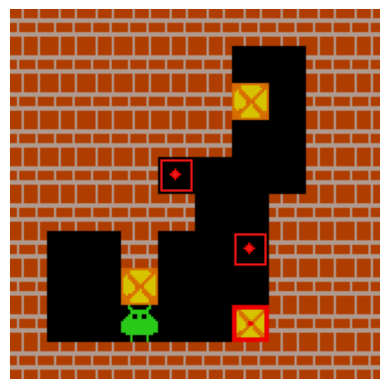

Agent Moved:


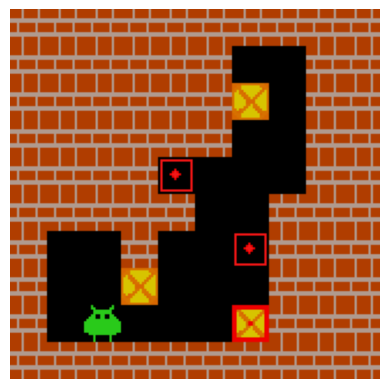

Agent Moved:


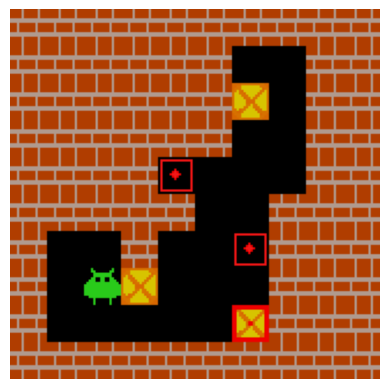

Agent Moved:


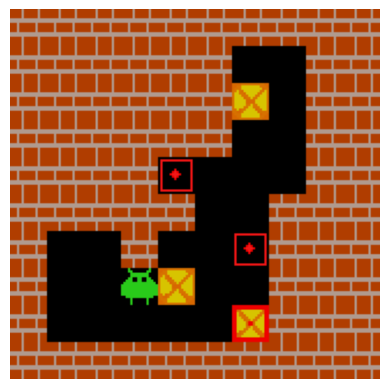

Agent Moved:


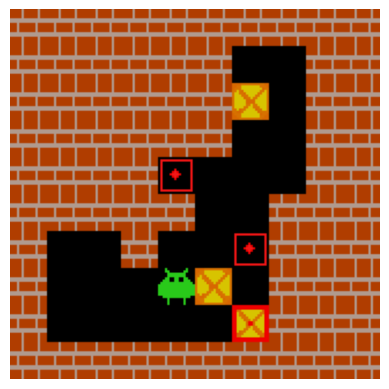

Agent Moved:


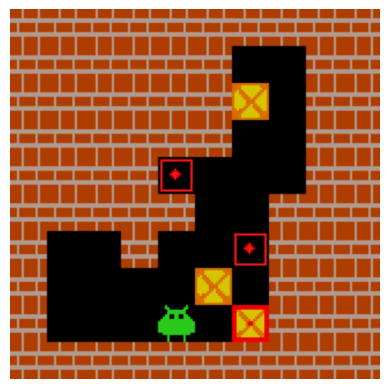

Agent Moved:


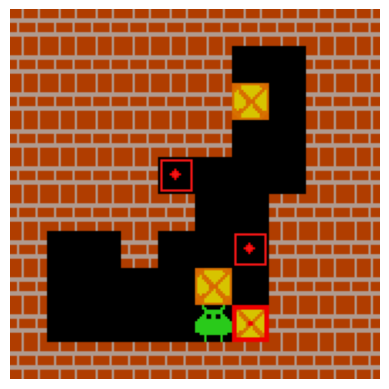

Agent Moved:


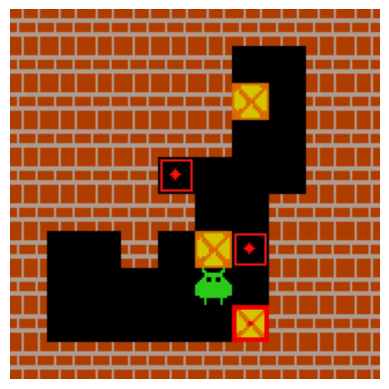

Agent Moved:


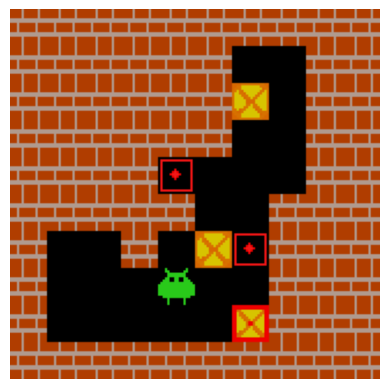

Agent Moved:


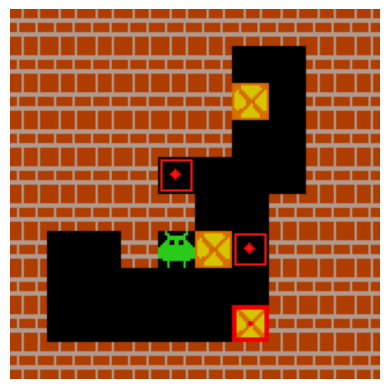

Agent Moved:


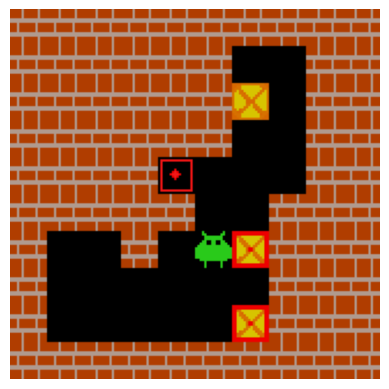

Agent Moved:


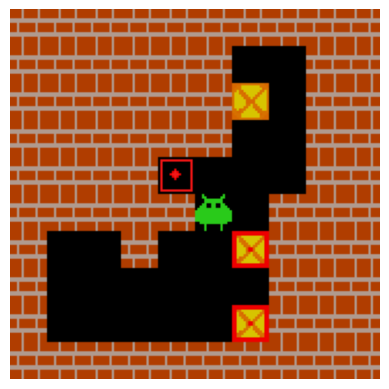

Agent Moved:


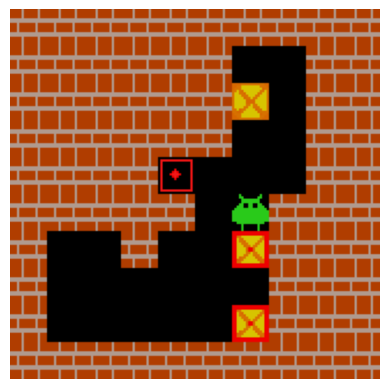

Agent Moved:


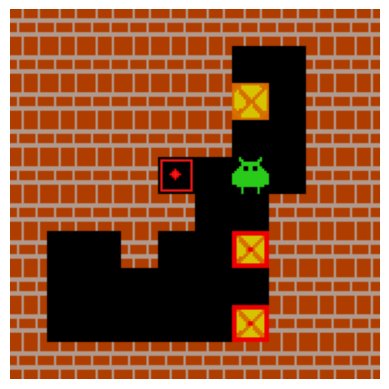

Agent Moved:


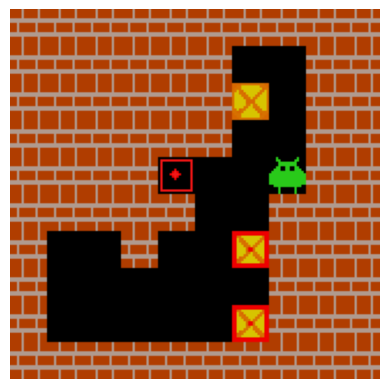

Agent Moved:


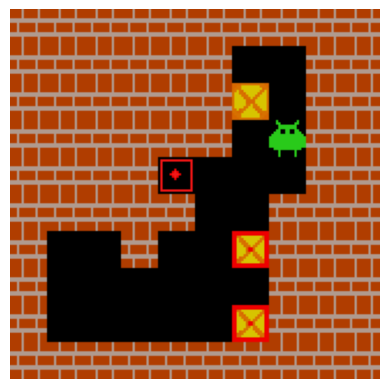

Agent Moved:


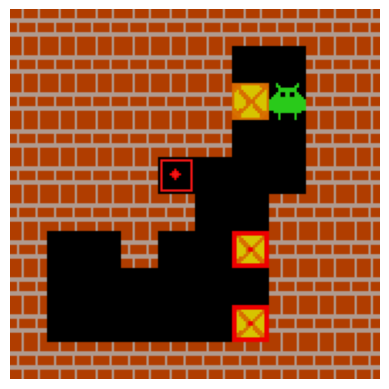

Agent Moved:


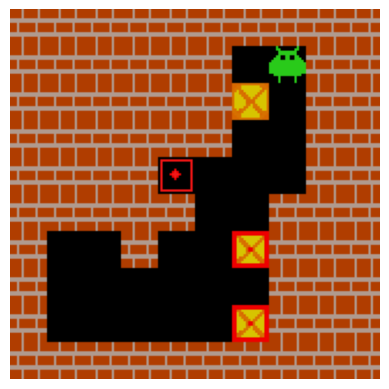

Agent Moved:


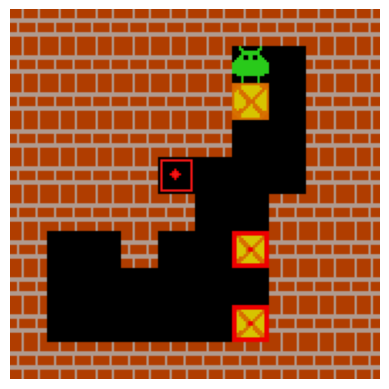

Agent Moved:


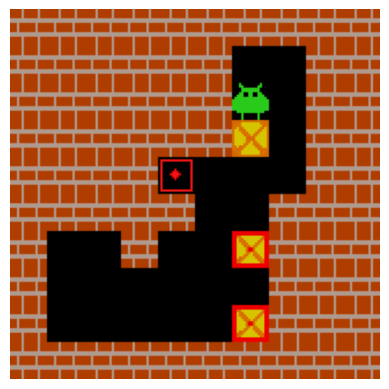

Agent Moved:


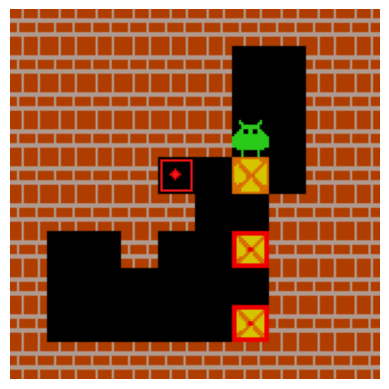

Agent Moved:


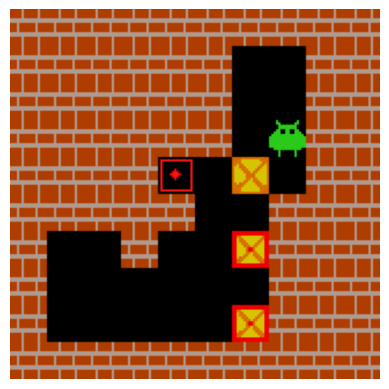

Agent Moved:


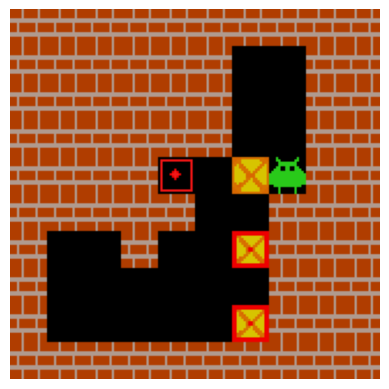

Agent Moved:


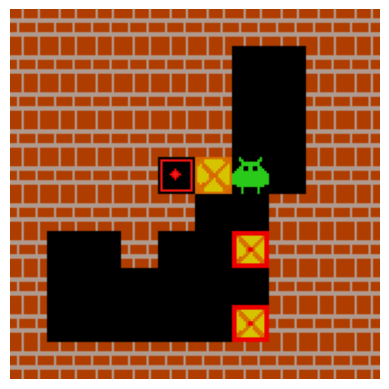

Agent Moved:


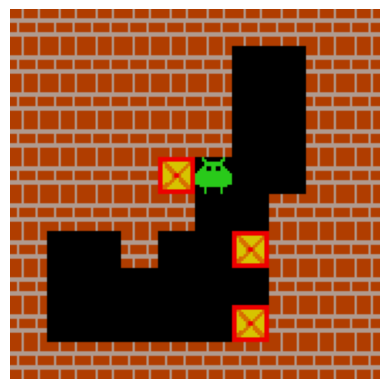

Goal Reached!


In [19]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_mc_model_pr2.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


Episode 0: Total Reward: -3122, Steps: 499
Episode 100: Total Reward: -3196, Steps: 499
Episode 200: Total Reward: -3160, Steps: 499
Episode 300: Total Reward: -1628, Steps: 499
Episode 400: Total Reward: -3101, Steps: 499
Episode 500: Total Reward: -1352, Steps: 499
Episode 600: Total Reward: -2549, Steps: 499
Episode 700: Total Reward: -1474, Steps: 499
Episode 800: Total Reward: -1773, Steps: 499
Episode 900: Total Reward: -1046, Steps: 499
Episode 1000: Total Reward: -992, Steps: 499
Episode 1100: Total Reward: -956, Steps: 499
Episode 1200: Total Reward: -3080, Steps: 499
Episode 1300: Total Reward: -839, Steps: 499
Episode 1400: Total Reward: -924, Steps: 499
Episode 1500: Total Reward: -1951, Steps: 499
Episode 1600: Total Reward: -913, Steps: 499
Episode 1700: Total Reward: -3114, Steps: 499
Episode 1800: Total Reward: -891, Steps: 499
Episode 1900: Total Reward: -938, Steps: 499
Episode 2000: Total Reward: -180, Steps: 43
Episode 2100: Total Reward: -967, Steps: 499
Episode 22

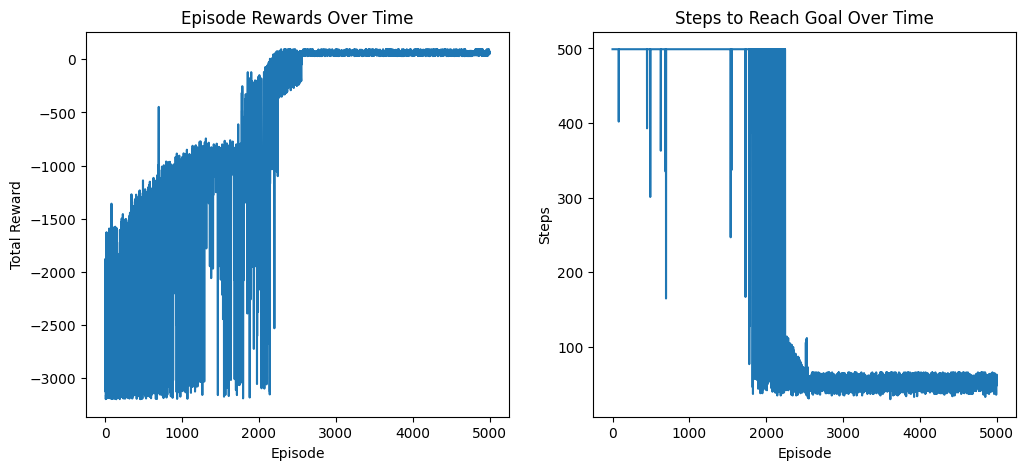

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_mc_model_pr3.pkl'

    # Train the agent using Monte-Carlo
    Q, mc_rewards_pr3, mc_steps_pr3 = monte_carlo(env, alpha=0.05, gamma=0.85, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.3, episodes=5000,
                max_steps=500)

    # Save the trained model
    save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(mc_rewards_pr3, mc_steps_pr3)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break

Model loaded from map2_mc_model_pr3.pkl
Initial State:


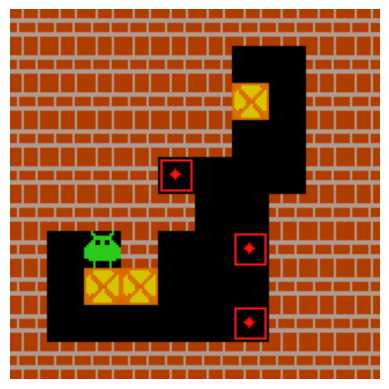

Agent Moved:


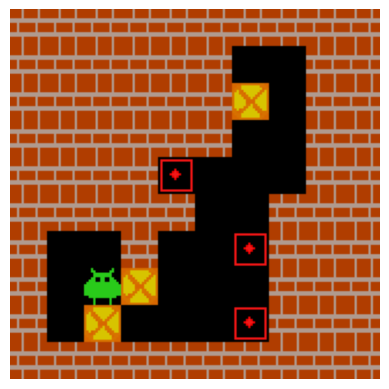

Agent Moved:


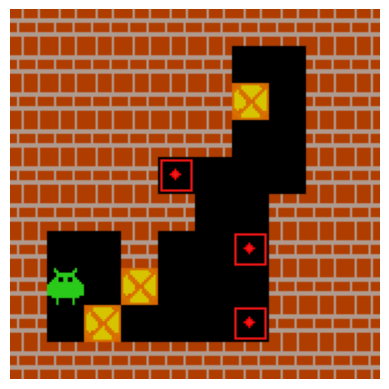

Agent Moved:


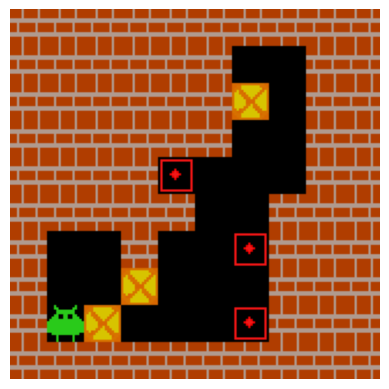

Agent Moved:


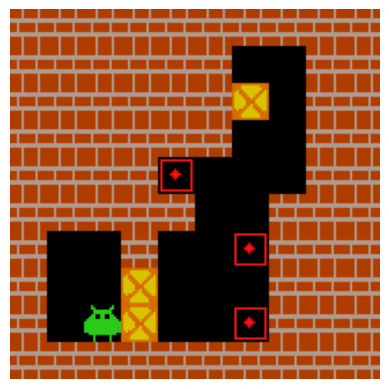

Agent Moved:


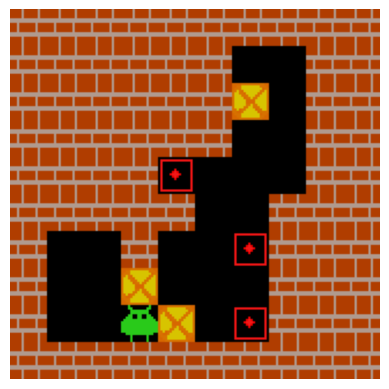

Agent Moved:


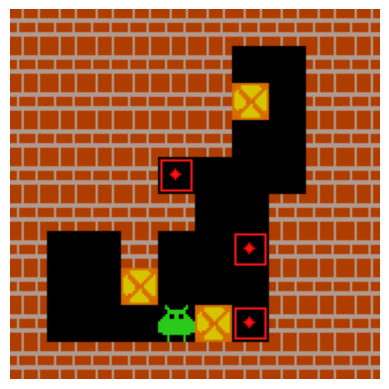

Agent Moved:


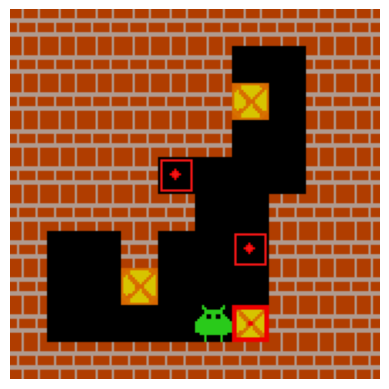

Agent Moved:


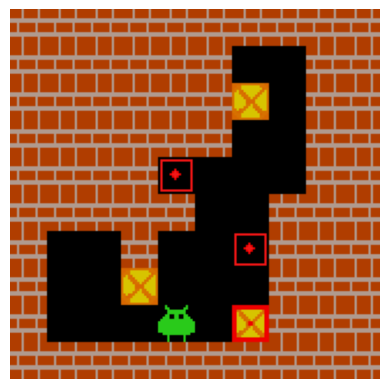

Agent Moved:


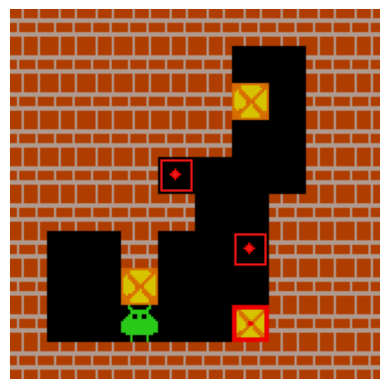

Agent Moved:


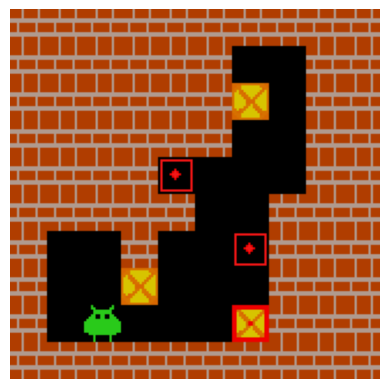

Agent Moved:


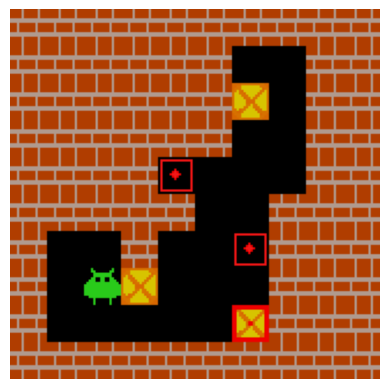

Agent Moved:


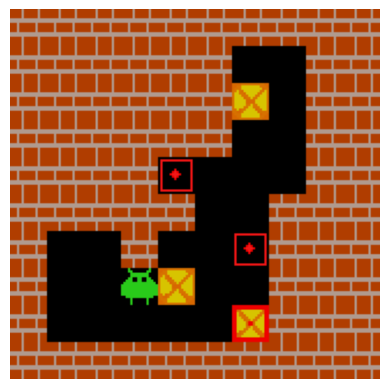

Agent Moved:


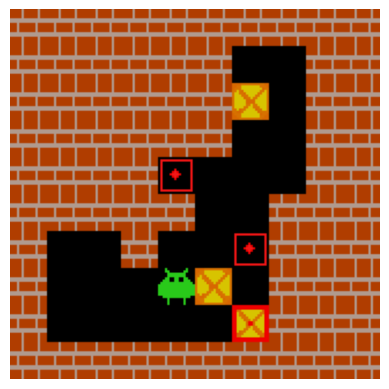

Agent Moved:


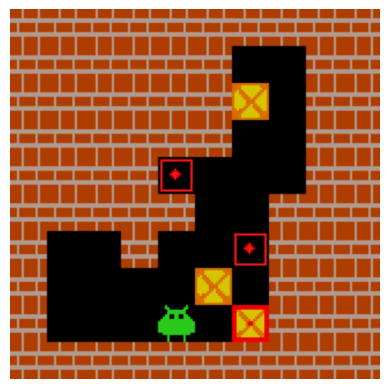

Agent Moved:


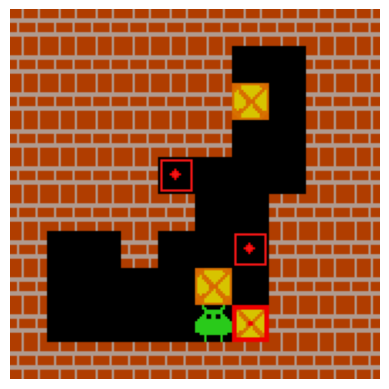

Agent Moved:


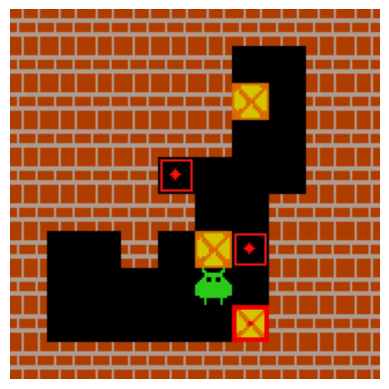

Agent Moved:


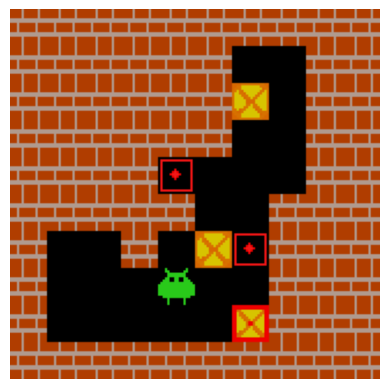

Agent Moved:


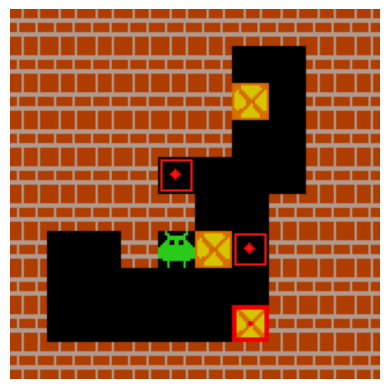

Agent Moved:


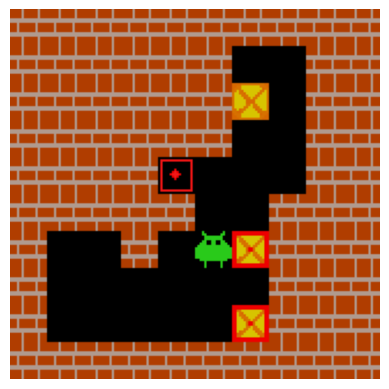

Agent Moved:


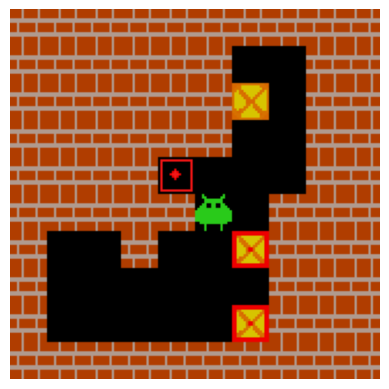

Agent Moved:


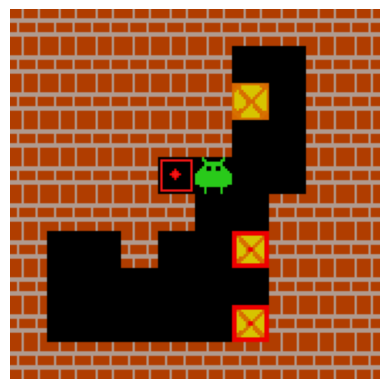

Agent Moved:


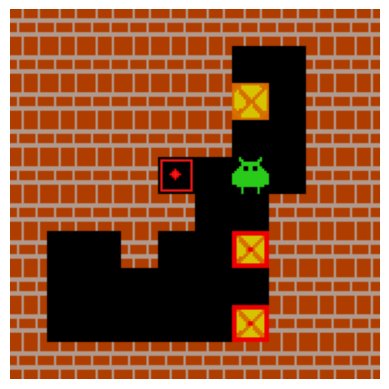

Agent Moved:


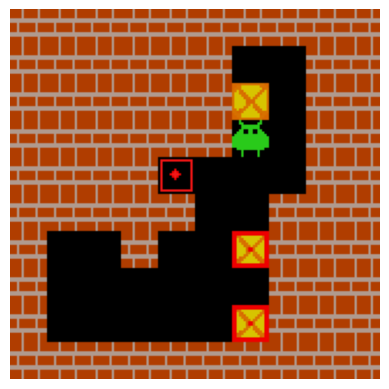

Agent Moved:


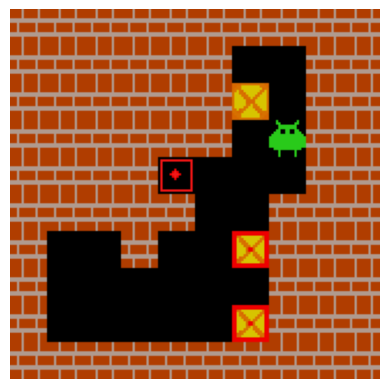

Agent Moved:


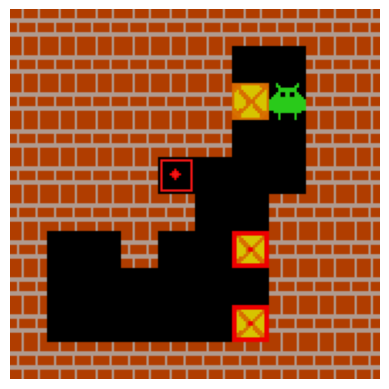

Agent Moved:


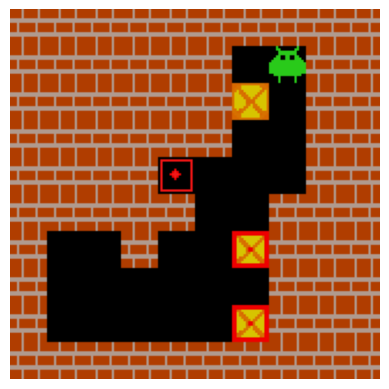

Agent Moved:


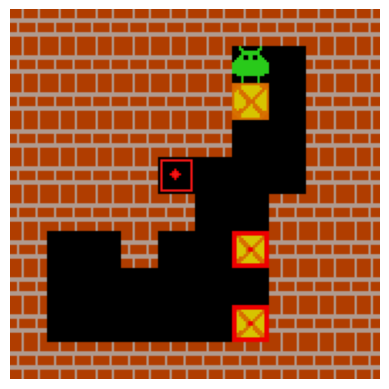

Agent Moved:


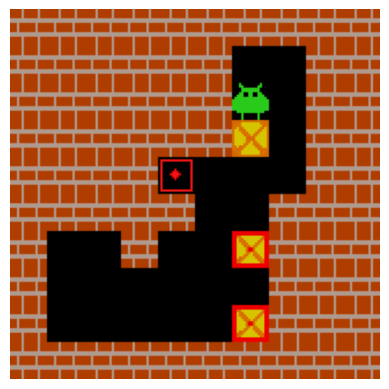

Agent Moved:


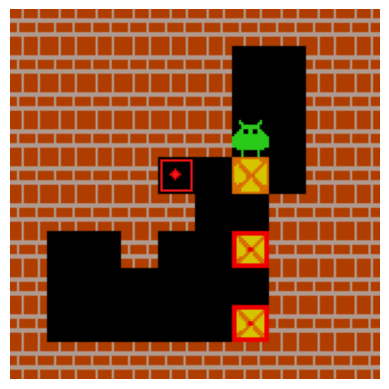

Agent Moved:


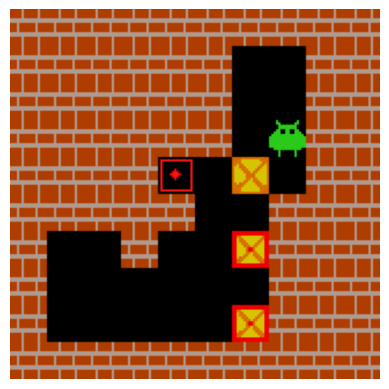

Agent Moved:


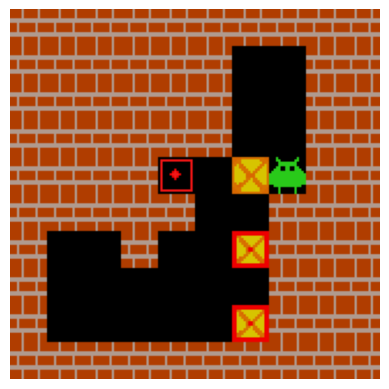

Agent Moved:


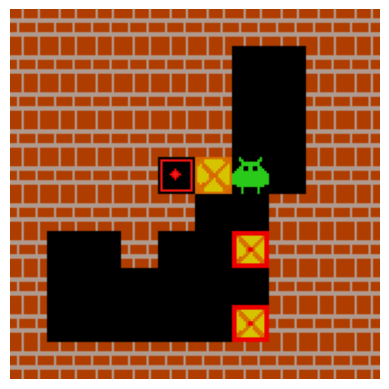

Agent Moved:


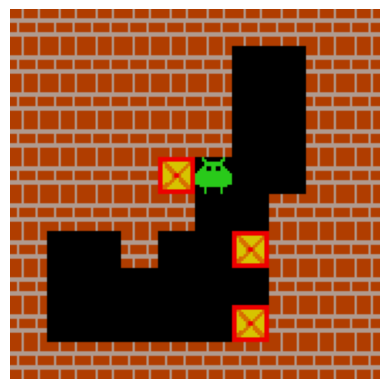

Goal Reached!


In [20]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_mc_model_pr3.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


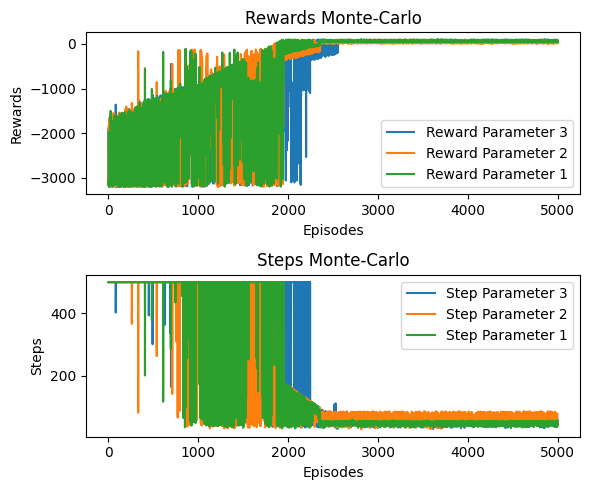

In [ ]:
model = 'Monte-Carlo'
plot_pr(model, mc_rewards_pr3,mc_rewards_pr2, mc_rewards_pr1 , mc_steps_pr3, mc_steps_pr2, mc_steps_pr1)

**Q-Learning**

In [ ]:
# Q-Learning algorithm
def q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps):
    # Q-table: maps from (state, action) -> Q-value
    Q = {}

    episode_rewards = []
    steps_to_goal = []

    for episode in range(episodes):
        state = np.copy(env)
        state_key = flatten_state(state)

        # Initialize Q-values for this state if not already present
        if state_key not in Q:
            Q[state_key] = np.zeros(4)  # 4 possible actions

        total_reward = 0
        step = 0
        previous_state = None

        for _ in range(max_steps):
            step += 1
            if np.random.rand() < epsilon:  # Explore
                action = np.random.randint(4)
            else:  # Exploit
                action = np.argmax(Q[state_key])

            children = generate_children(state, previous_state)
            next_state, reward = children[action]

            next_state_key = flatten_state(next_state)

            # Initialize Q-values for the next state if not already present
            if next_state_key not in Q:
                Q[next_state_key] = np.zeros(4)

            # Q-learning update rule
            Q[state_key][action] = Q[state_key][action] + alpha * (
                reward + gamma * np.max(Q[next_state_key]) - Q[state_key][action]
            )

            state = next_state
            state_key = next_state_key
            total_reward += reward

            if is_goal(state):
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon

        episode_rewards.append(total_reward)
        steps_to_goal.append(step)
        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}, Steps: {step}")

    return Q, episode_rewards, steps_to_goal

Episode 0: Total Reward: -3179, Steps: 500
Episode 100: Total Reward: -3171, Steps: 500
Episode 200: Total Reward: -659, Steps: 500
Episode 300: Total Reward: -3023, Steps: 500
Episode 400: Total Reward: -3024, Steps: 500
Episode 500: Total Reward: 116, Steps: 37
Episode 600: Total Reward: 102, Steps: 39
Episode 700: Total Reward: 12, Steps: 120
Episode 800: Total Reward: 104, Steps: 40
Episode 900: Total Reward: 116, Steps: 34
Episode 1000: Total Reward: 112, Steps: 38
Episode 1100: Total Reward: 120, Steps: 33
Episode 1200: Total Reward: 112, Steps: 41
Episode 1300: Total Reward: 114, Steps: 36
Episode 1400: Total Reward: 110, Steps: 36
Episode 1500: Total Reward: 116, Steps: 34
Episode 1600: Total Reward: 110, Steps: 40
Episode 1700: Total Reward: 110, Steps: 37
Episode 1800: Total Reward: 114, Steps: 36
Episode 1900: Total Reward: 116, Steps: 37
Episode 2000: Total Reward: 112, Steps: 38
Episode 2100: Total Reward: 108, Steps: 39
Episode 2200: Total Reward: 118, Steps: 35
Episode 2

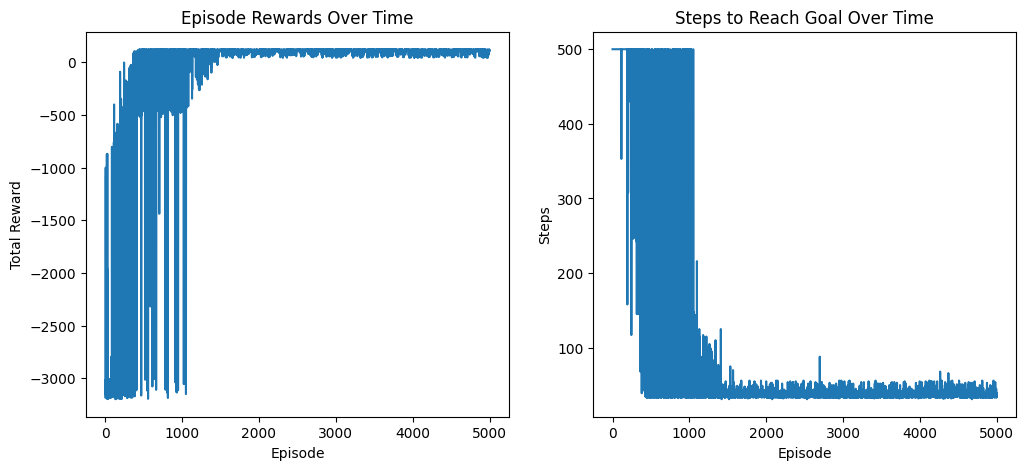

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_ql_model_pr1.pkl'

    # Train the agent using Q-learning
    Q, ql_rewards_pr1, ql_steps_pr1 = q_learning(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, episodes=5000, max_steps=500)

    # Save the trained model
    save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(ql_rewards_pr1, ql_steps_pr1)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action from the Q-table
        action = np.argmax(Q[state_key])
        children = generate_children(state, None)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break

Model loaded from map2_ql_model_pr1.pkl
Initial State:


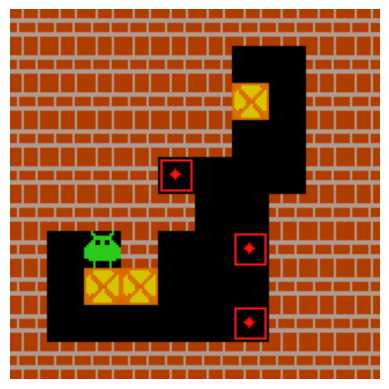

Agent Moved:


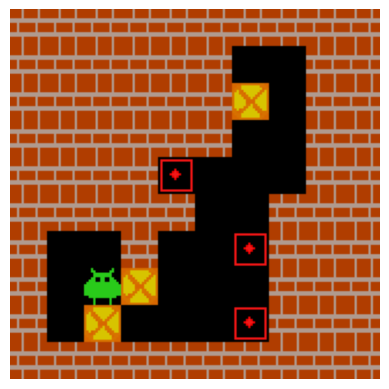

Agent Moved:


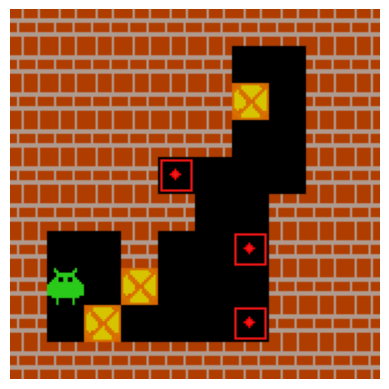

Agent Moved:


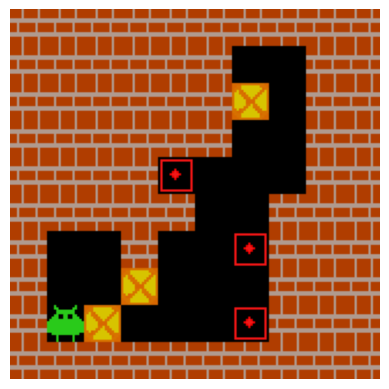

Agent Moved:


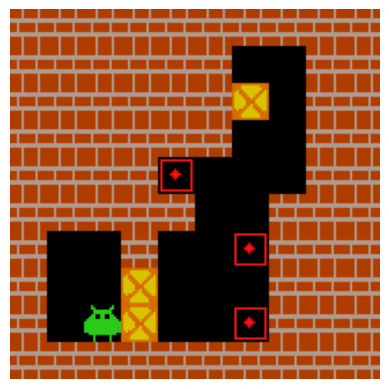

Agent Moved:


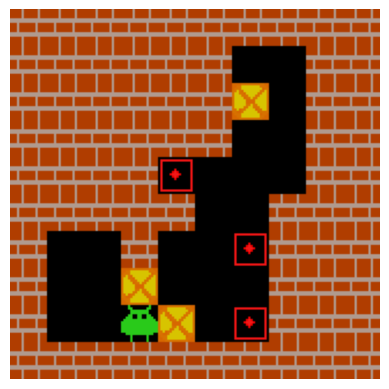

Agent Moved:


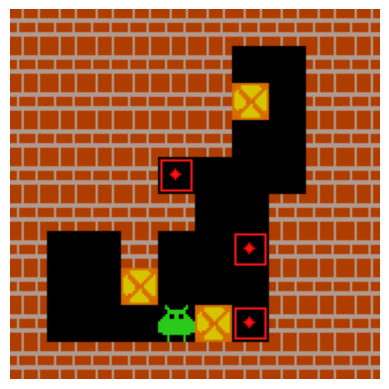

Agent Moved:


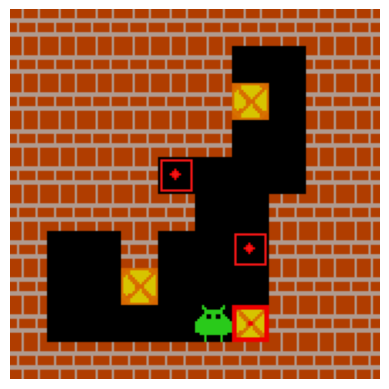

Agent Moved:


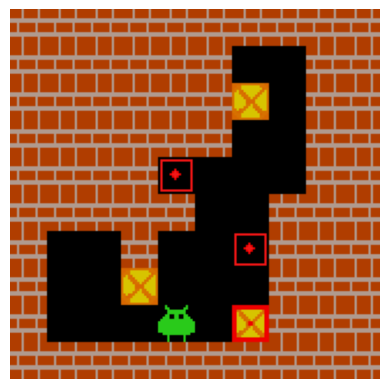

Agent Moved:


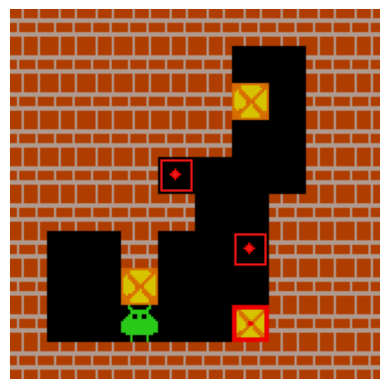

Agent Moved:


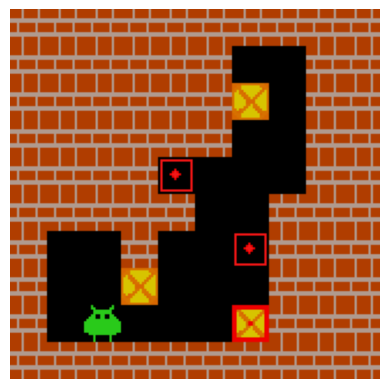

Agent Moved:


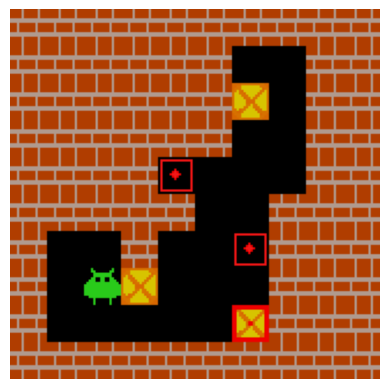

Agent Moved:


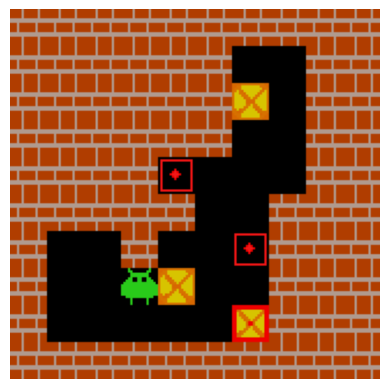

Agent Moved:


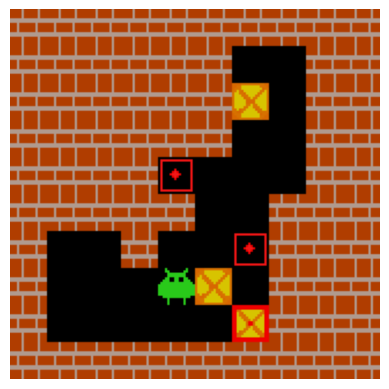

Agent Moved:


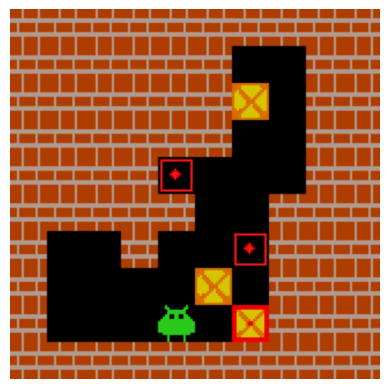

Agent Moved:


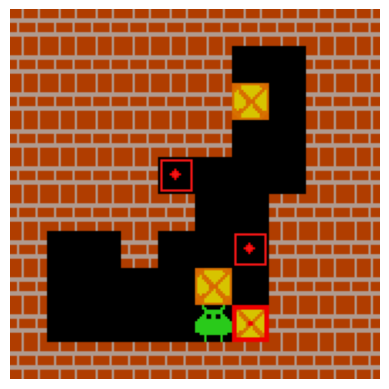

Agent Moved:


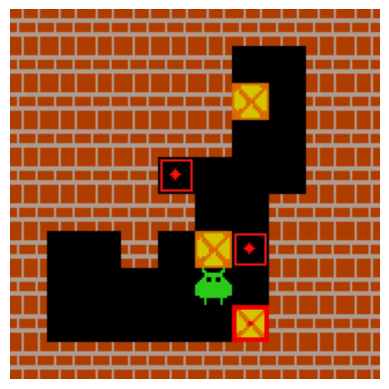

Agent Moved:


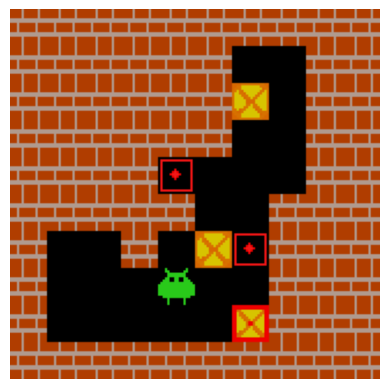

Agent Moved:


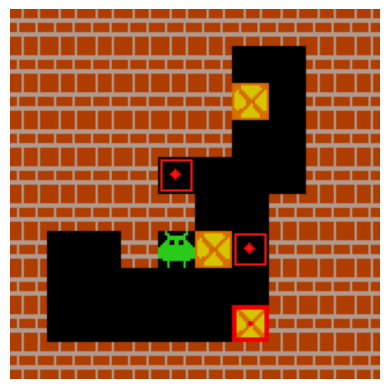

Agent Moved:


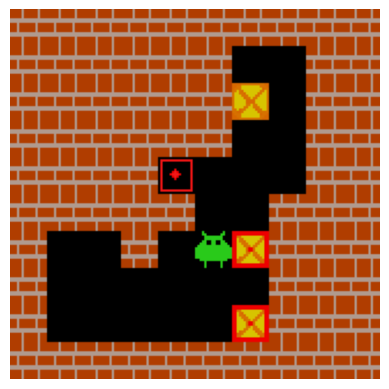

Agent Moved:


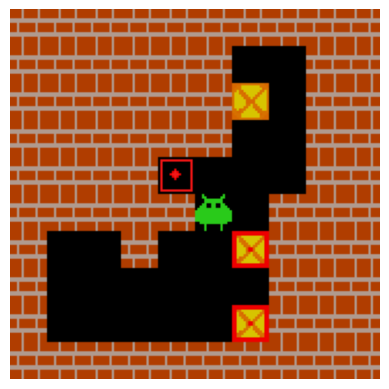

Agent Moved:


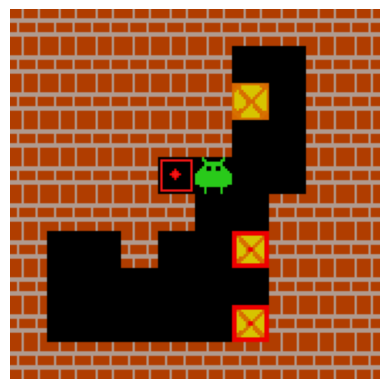

Agent Moved:


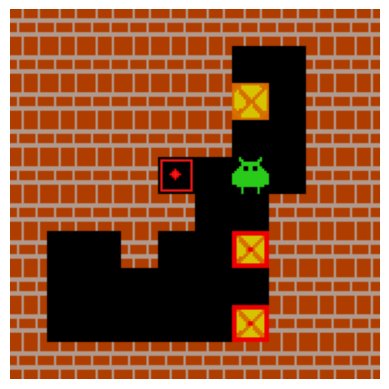

Agent Moved:


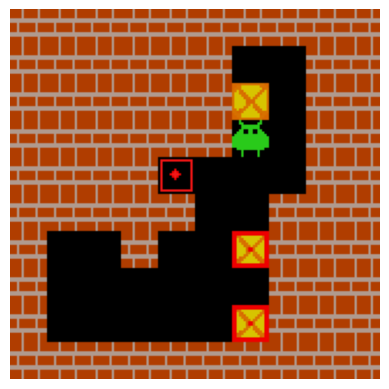

Agent Moved:


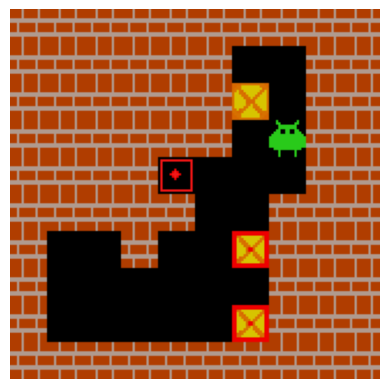

Agent Moved:


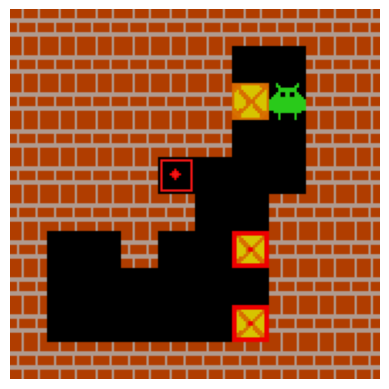

Agent Moved:


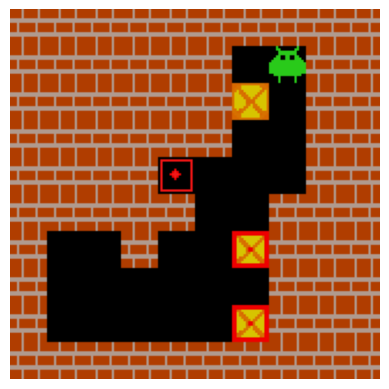

Agent Moved:


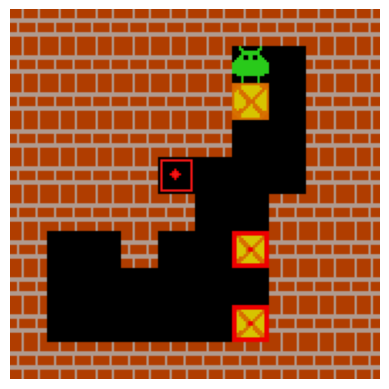

Agent Moved:


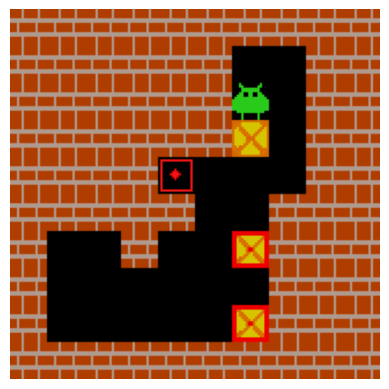

Agent Moved:


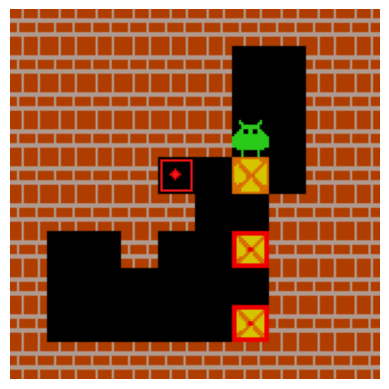

Agent Moved:


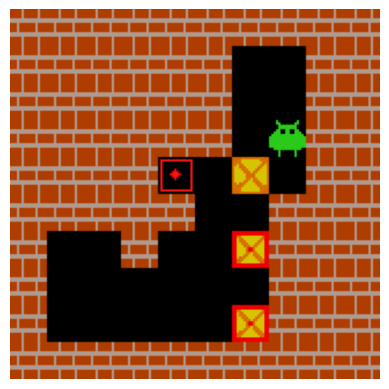

Agent Moved:


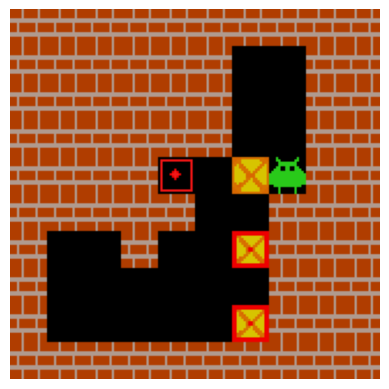

Agent Moved:


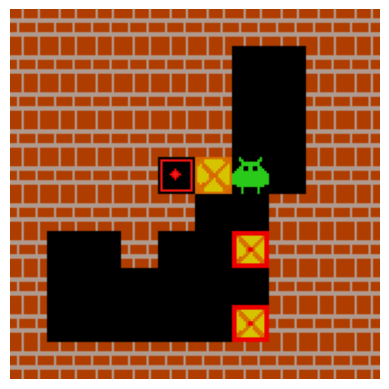

Agent Moved:


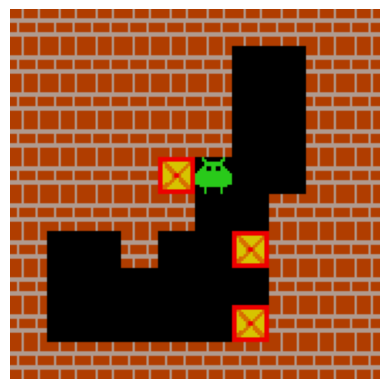

Goal Reached!


In [21]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_ql_model_pr1.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


Episode 0: Total Reward: -3065, Steps: 500
Episode 100: Total Reward: -3008, Steps: 500
Episode 200: Total Reward: -3170, Steps: 500
Episode 300: Total Reward: -3016, Steps: 500
Episode 400: Total Reward: 118, Steps: 35
Episode 500: Total Reward: 112, Steps: 38
Episode 600: Total Reward: -471, Steps: 500
Episode 700: Total Reward: 108, Steps: 45
Episode 800: Total Reward: 118, Steps: 35
Episode 900: Total Reward: 110, Steps: 37
Episode 1000: Total Reward: 118, Steps: 35
Episode 1100: Total Reward: 98, Steps: 39
Episode 1200: Total Reward: -174, Steps: 162
Episode 1300: Total Reward: 112, Steps: 38
Episode 1400: Total Reward: 114, Steps: 36
Episode 1500: Total Reward: 106, Steps: 44
Episode 1600: Total Reward: 106, Steps: 37
Episode 1700: Total Reward: 118, Steps: 35
Episode 1800: Total Reward: 102, Steps: 39
Episode 1900: Total Reward: 118, Steps: 35
Episode 2000: Total Reward: 18, Steps: 52
Episode 2100: Total Reward: 112, Steps: 41
Episode 2200: Total Reward: 120, Steps: 33
Episode 2

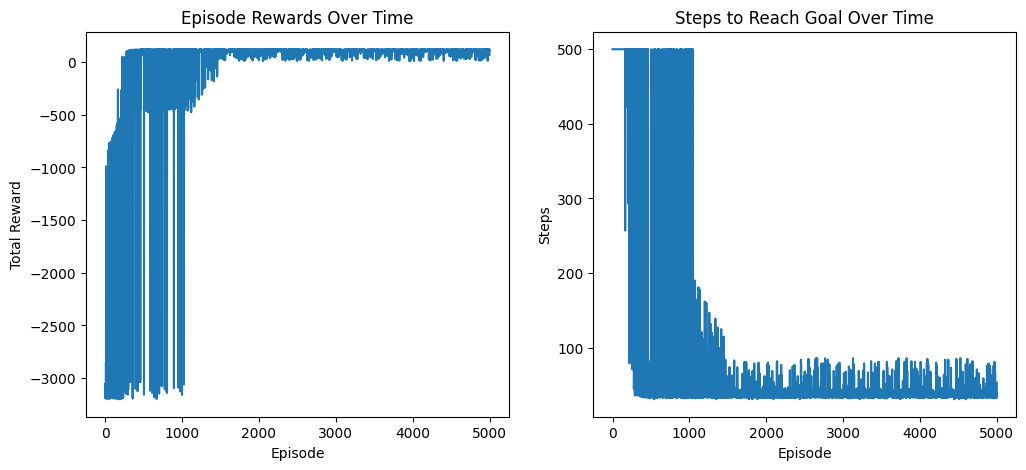

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_ql_model_pr2.pkl'

    # Train the agent using Q-learning
    Q, ql_rewards_pr2, ql_steps_pr2 = q_learning(env, alpha=0.2, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, episodes=5000, max_steps=500)

    # Save the trained model
    save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(ql_rewards_pr2, ql_steps_pr2)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action from the Q-table
        action = np.argmax(Q[state_key])
        children = generate_children(state, None)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break

Model loaded from map2_ql_model_pr2.pkl
Initial State:


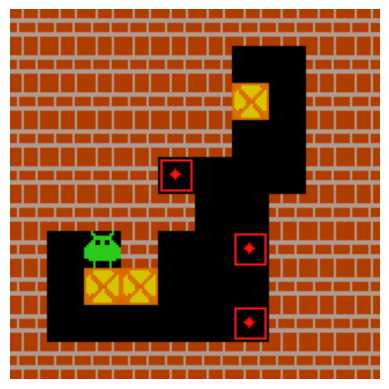

Agent Moved:


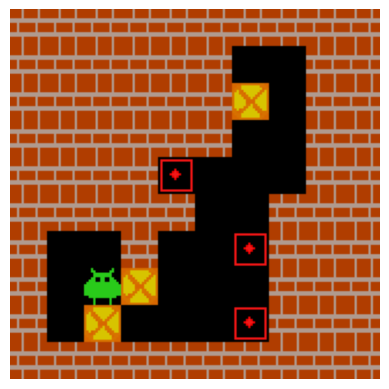

Agent Moved:


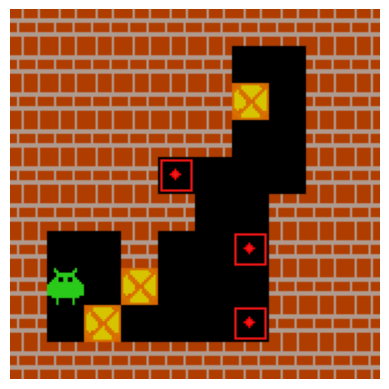

Agent Moved:


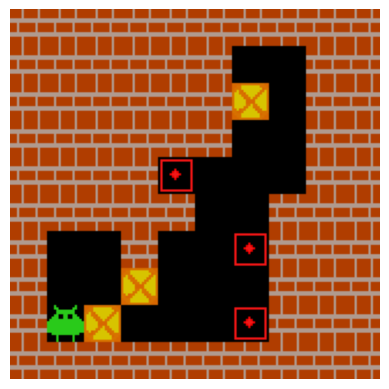

Agent Moved:


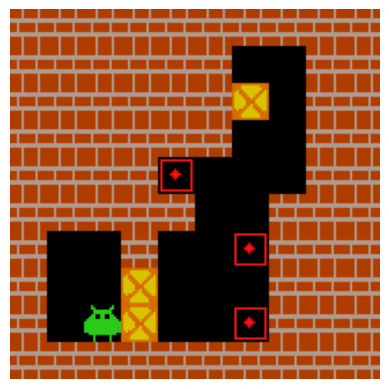

Agent Moved:


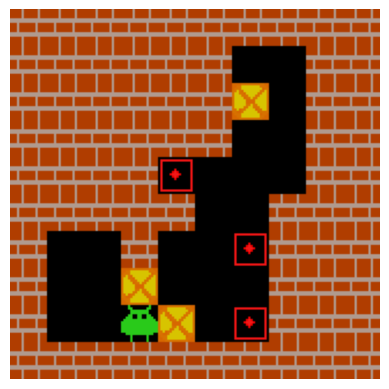

Agent Moved:


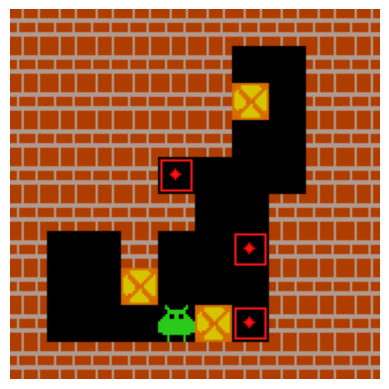

Agent Moved:


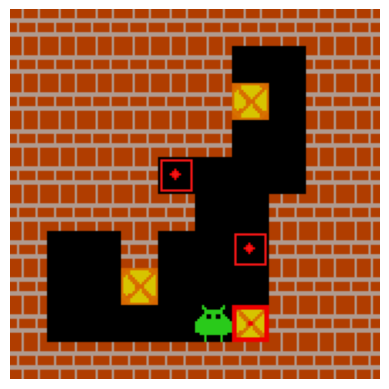

Agent Moved:


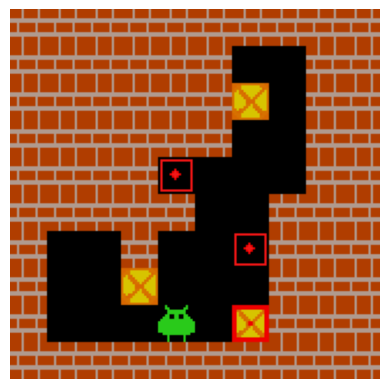

Agent Moved:


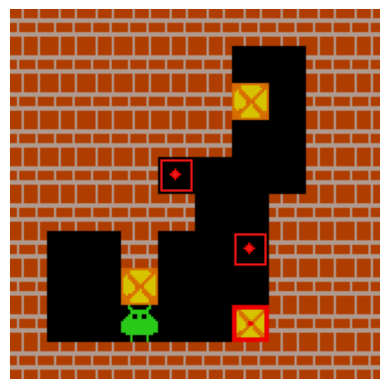

Agent Moved:


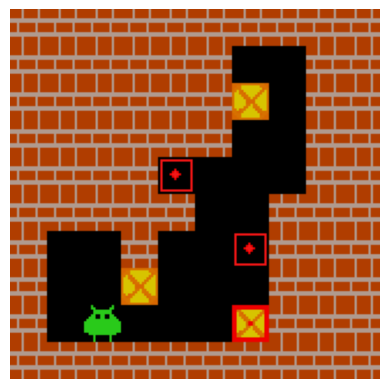

Agent Moved:


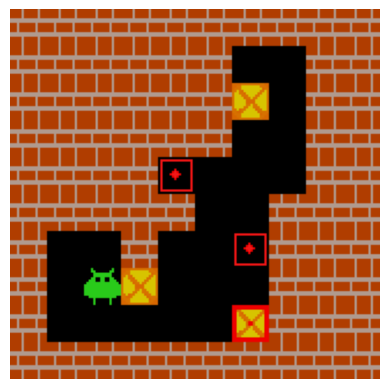

Agent Moved:


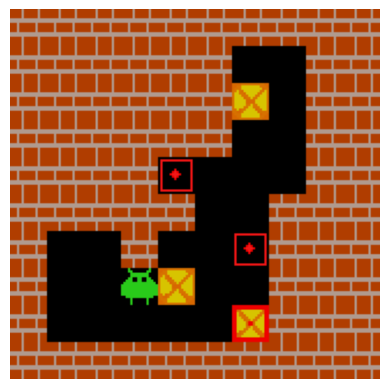

Agent Moved:


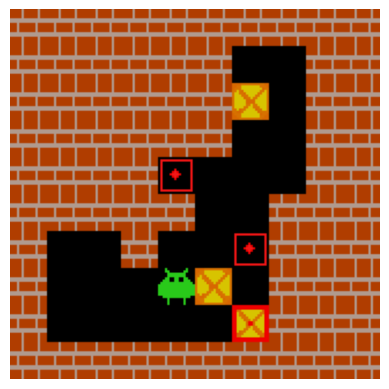

Agent Moved:


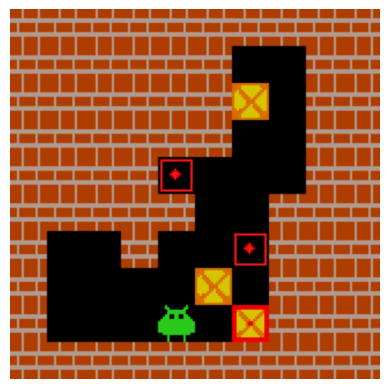

Agent Moved:


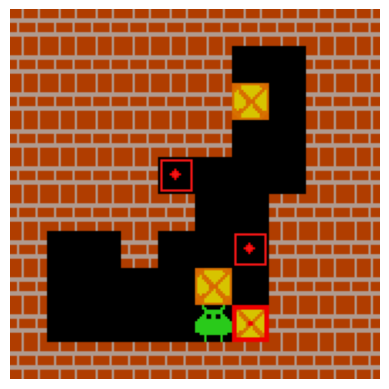

Agent Moved:


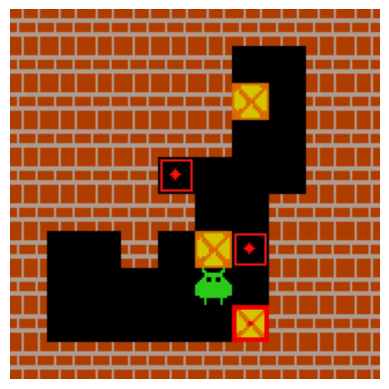

Agent Moved:


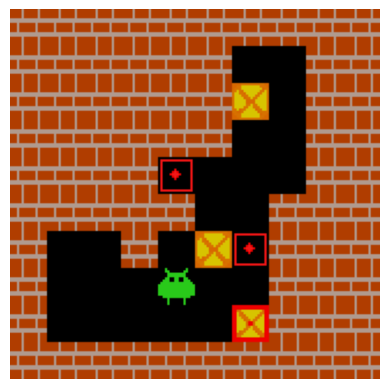

Agent Moved:


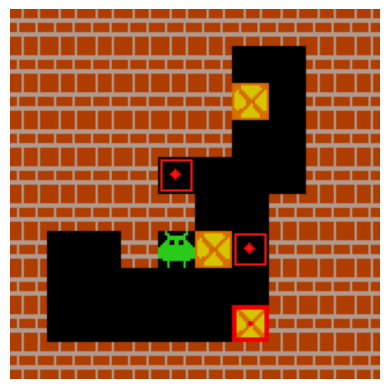

Agent Moved:


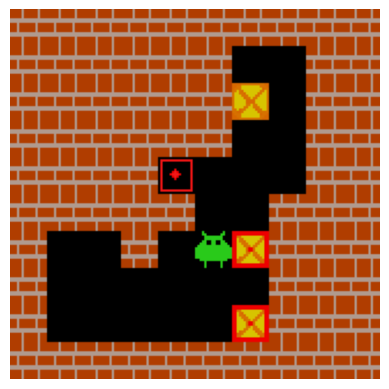

Agent Moved:


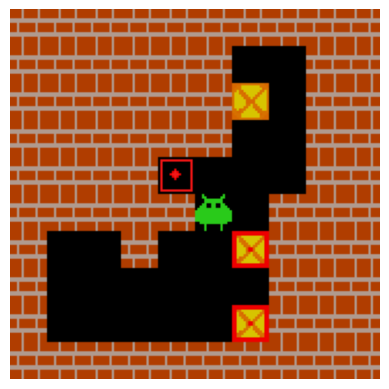

Agent Moved:


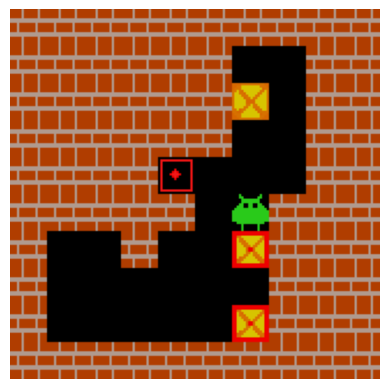

Agent Moved:


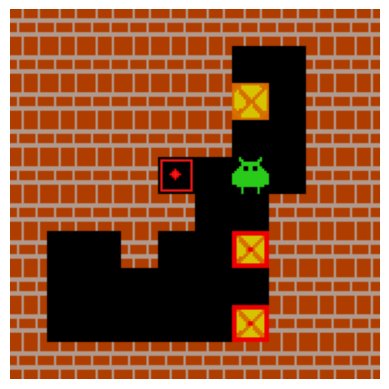

Agent Moved:


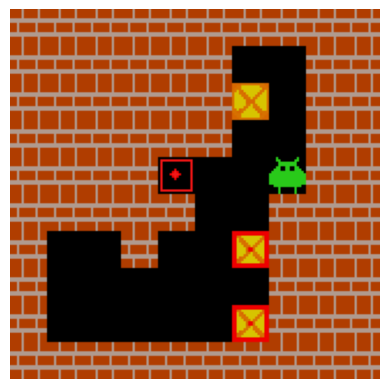

Agent Moved:


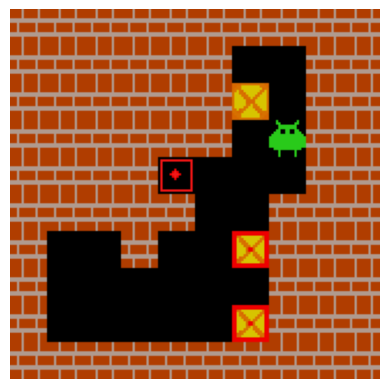

Agent Moved:


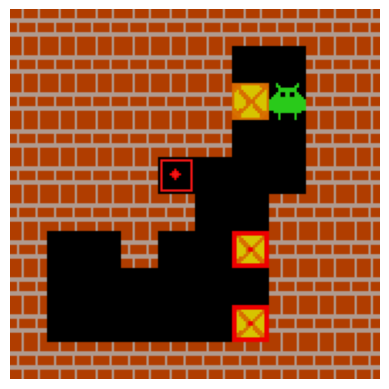

Agent Moved:


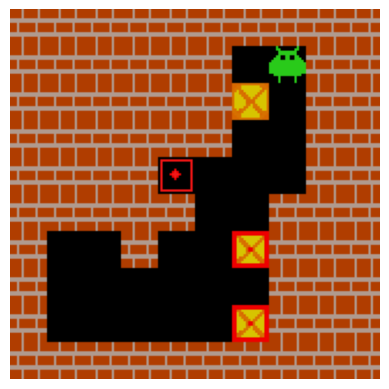

Agent Moved:


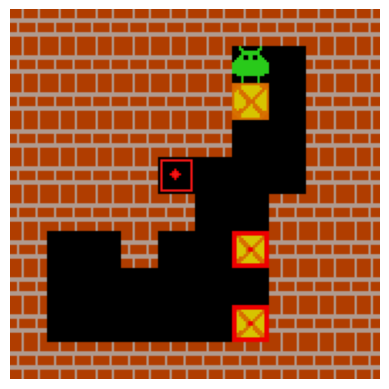

Agent Moved:


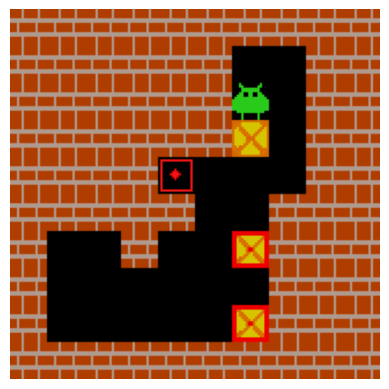

Agent Moved:


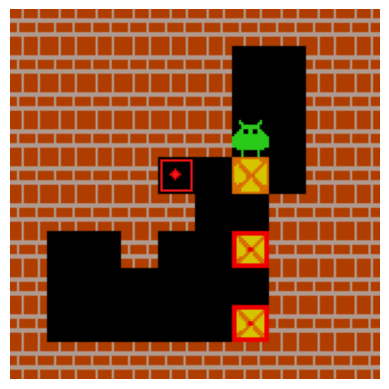

Agent Moved:


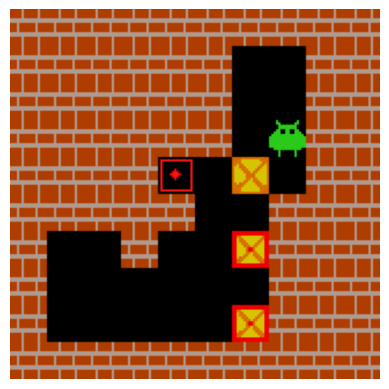

Agent Moved:


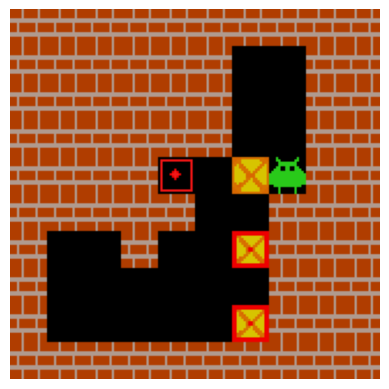

Agent Moved:


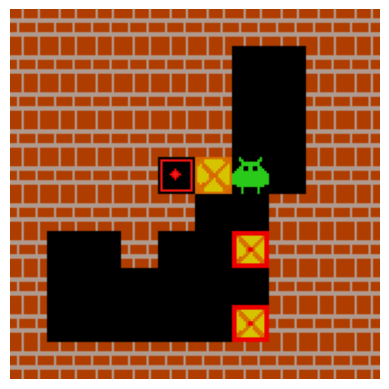

Agent Moved:


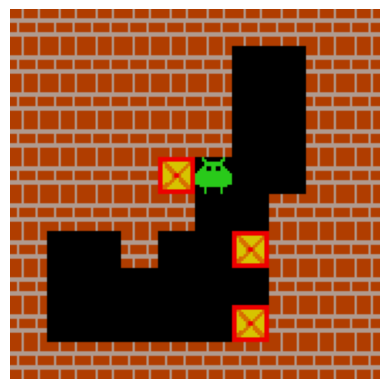

Goal Reached!


In [22]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_ql_model_pr2.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


Episode 0: Total Reward: -3022, Steps: 500
Episode 100: Total Reward: -3178, Steps: 500
Episode 200: Total Reward: -604, Steps: 500
Episode 300: Total Reward: -3092, Steps: 500
Episode 400: Total Reward: -222, Steps: 294
Episode 500: Total Reward: -490, Steps: 500
Episode 600: Total Reward: 58, Steps: 76
Episode 700: Total Reward: 114, Steps: 36
Episode 800: Total Reward: 30, Steps: 93
Episode 900: Total Reward: 108, Steps: 45
Episode 1000: Total Reward: 98, Steps: 43
Episode 1100: Total Reward: 118, Steps: 35
Episode 1200: Total Reward: 96, Steps: 37
Episode 1300: Total Reward: 116, Steps: 34
Episode 1400: Total Reward: 116, Steps: 37
Episode 1500: Total Reward: 110, Steps: 37
Episode 1600: Total Reward: 112, Steps: 38
Episode 1700: Total Reward: 118, Steps: 35
Episode 1800: Total Reward: 104, Steps: 43
Episode 1900: Total Reward: 110, Steps: 37
Episode 2000: Total Reward: 104, Steps: 49
Episode 2100: Total Reward: 106, Steps: 38
Episode 2200: Total Reward: 96, Steps: 44
Episode 2300:

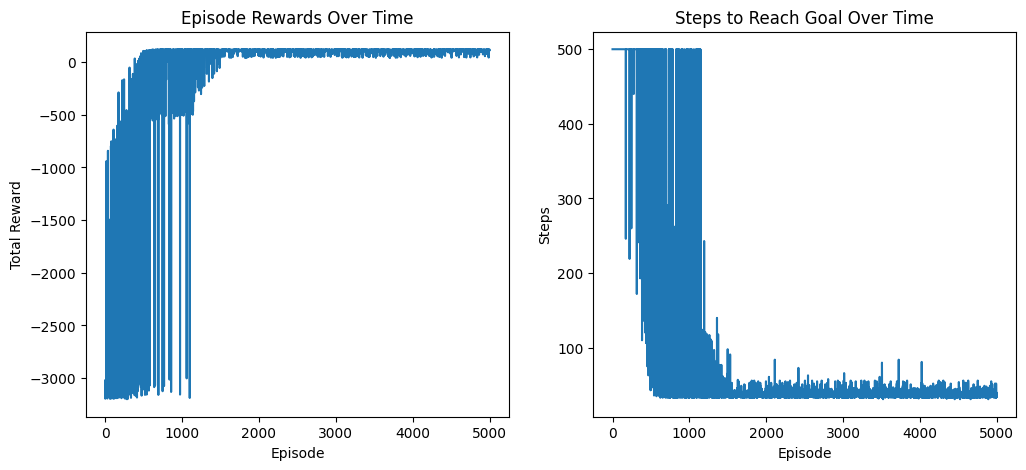

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_ql_model_pr3.pkl'

    # Train the agent using Q-learning
    Q, ql_rewards_pr3, ql_steps_pr3 = q_learning(env, alpha=0.05, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, episodes=5000, max_steps=500)

    # Save the trained model
    save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(ql_rewards_pr3, ql_steps_pr3)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action from the Q-table
        action = np.argmax(Q[state_key])
        children = generate_children(state, None)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break

Model loaded from map2_ql_model_pr3.pkl
Initial State:


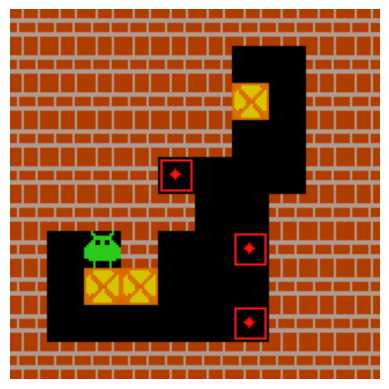

Agent Moved:


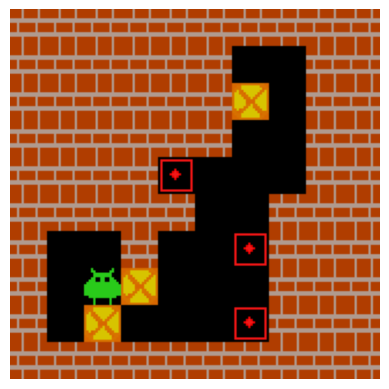

Agent Moved:


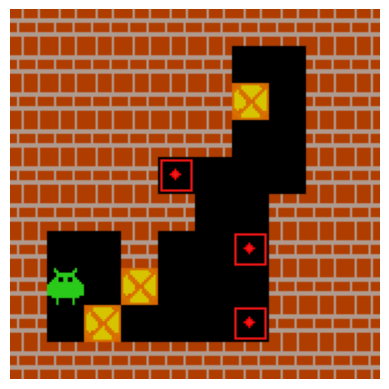

Agent Moved:


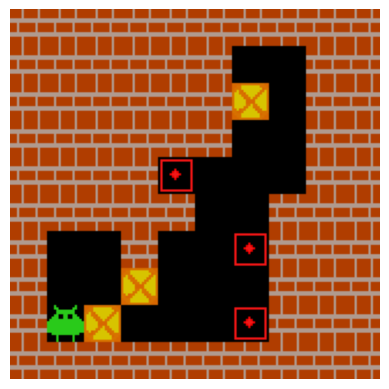

Agent Moved:


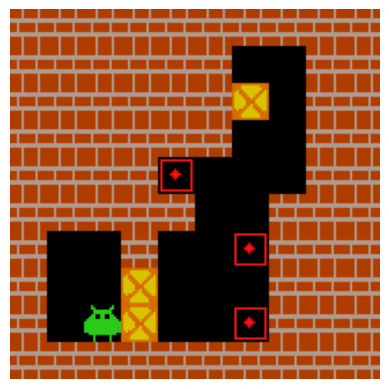

Agent Moved:


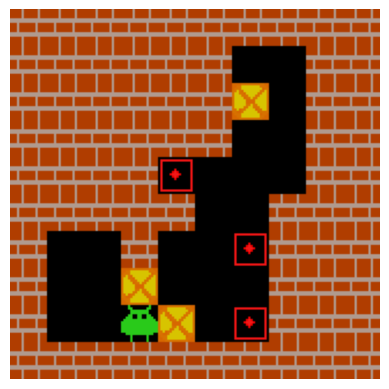

Agent Moved:


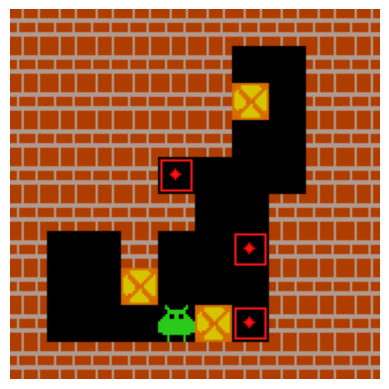

Agent Moved:


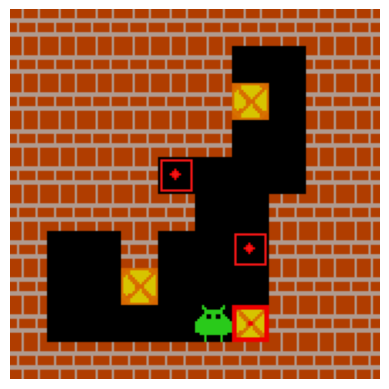

Agent Moved:


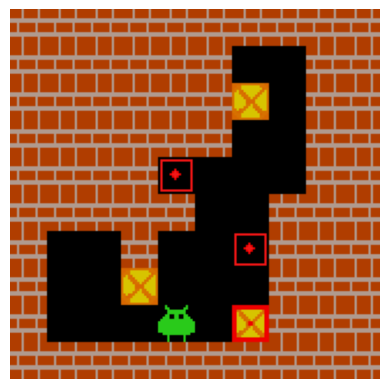

Agent Moved:


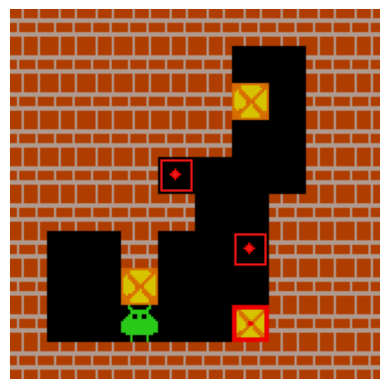

Agent Moved:


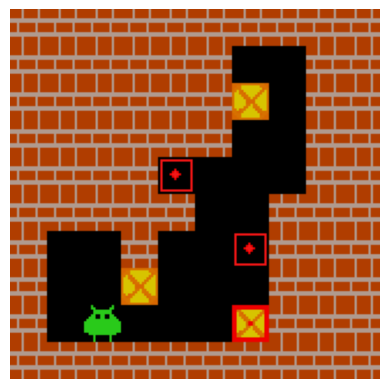

Agent Moved:


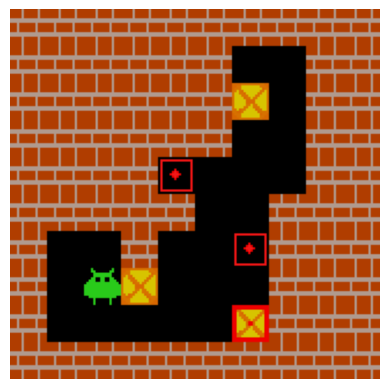

Agent Moved:


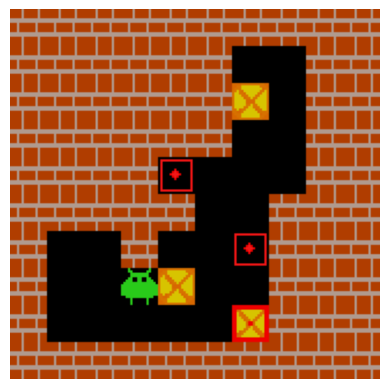

Agent Moved:


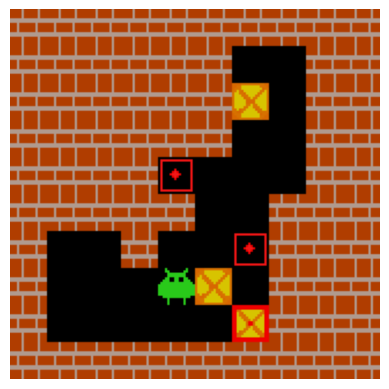

Agent Moved:


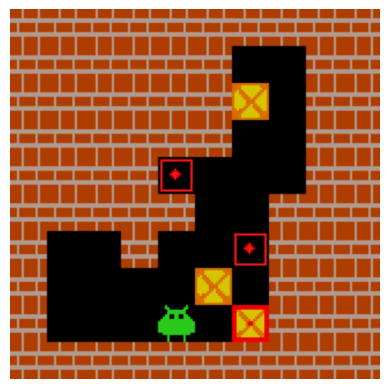

Agent Moved:


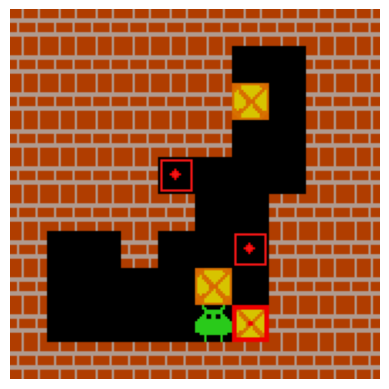

Agent Moved:


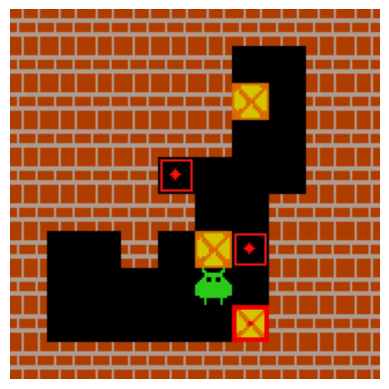

Agent Moved:


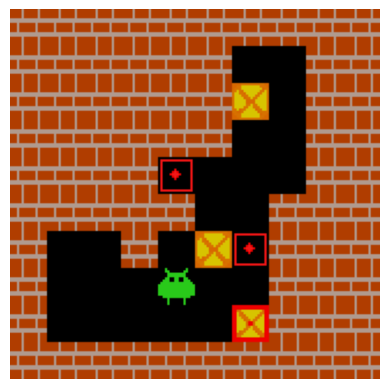

Agent Moved:


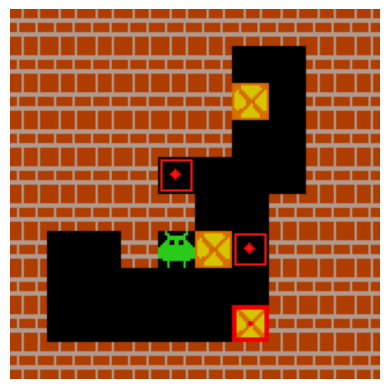

Agent Moved:


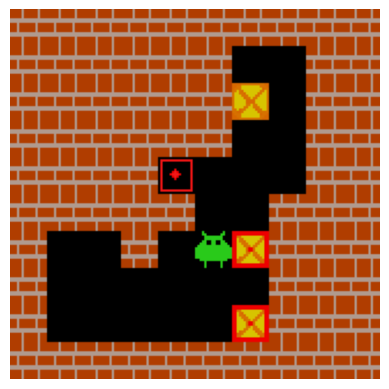

Agent Moved:


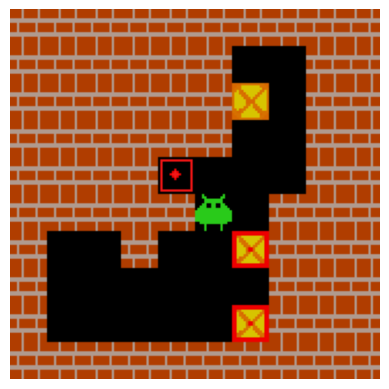

Agent Moved:


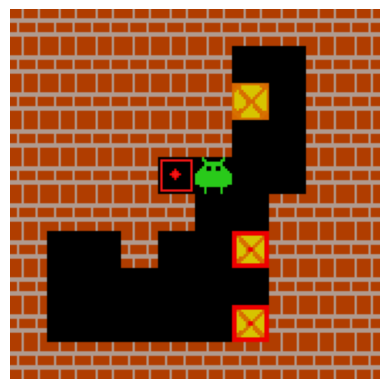

Agent Moved:


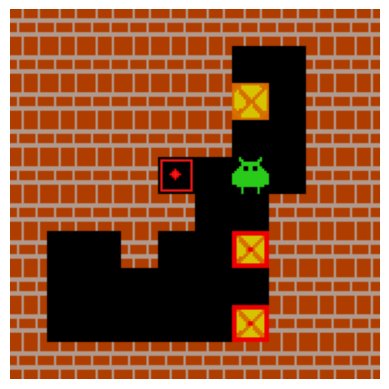

Agent Moved:


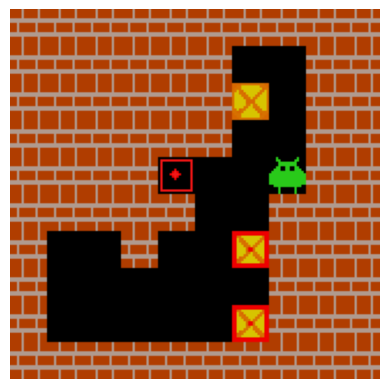

Agent Moved:


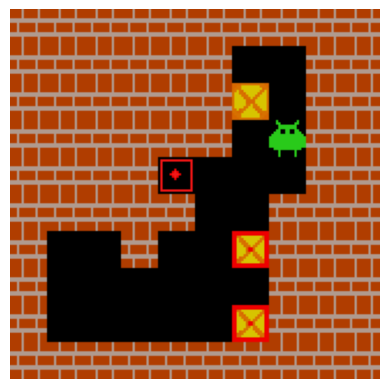

Agent Moved:


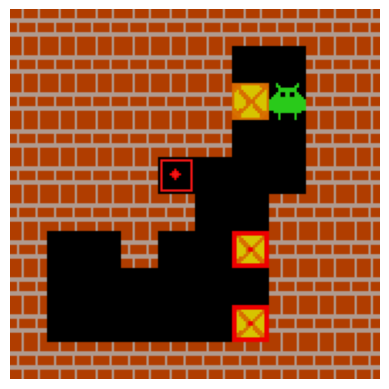

Agent Moved:


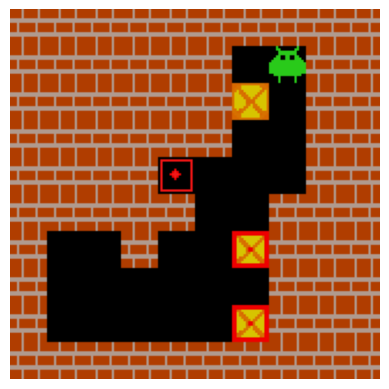

Agent Moved:


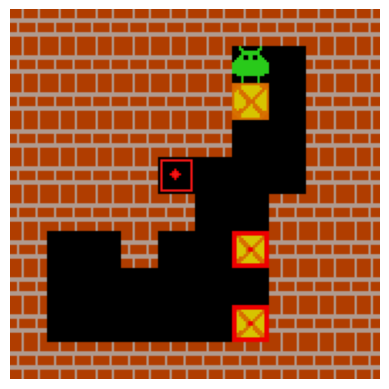

Agent Moved:


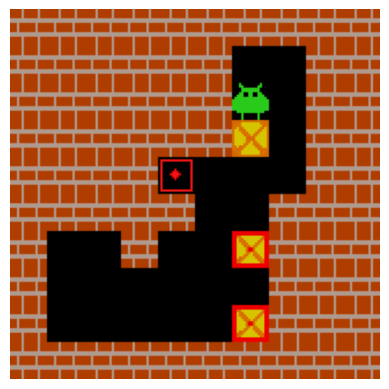

Agent Moved:


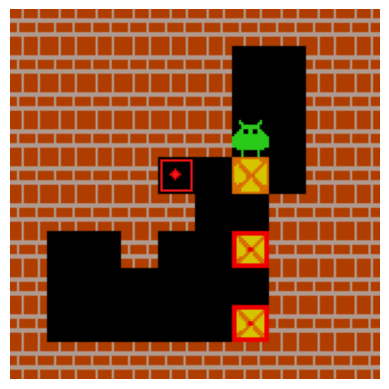

Agent Moved:


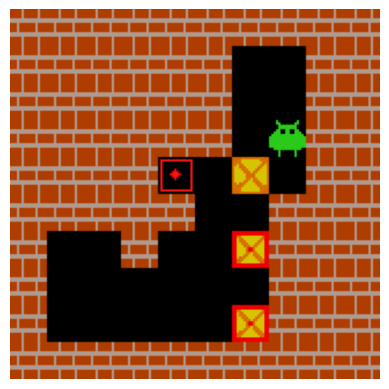

Agent Moved:


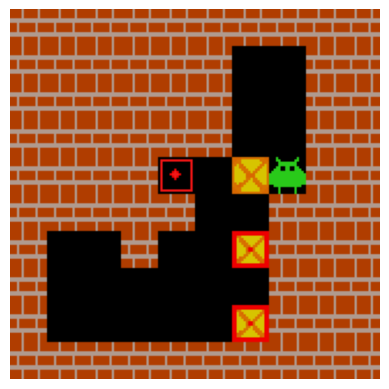

Agent Moved:


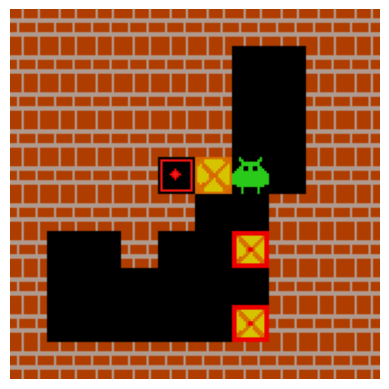

Agent Moved:


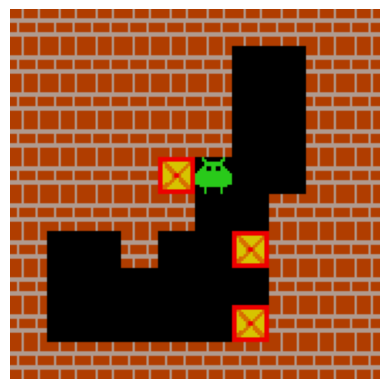

Goal Reached!


In [23]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_ql_model_pr3.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


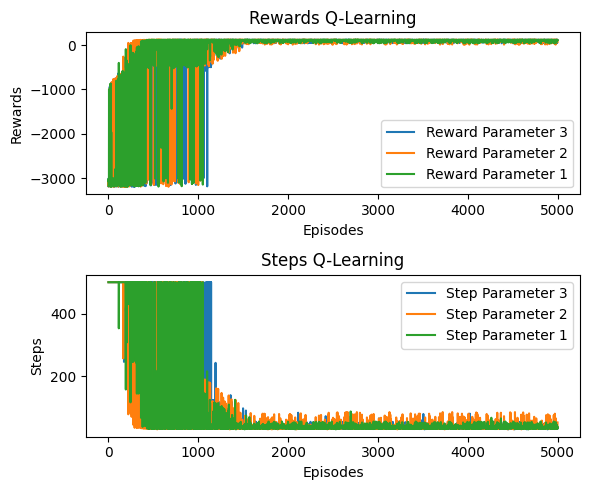

In [ ]:
model = 'Q-Learning'
plot_pr(model, ql_rewards_pr3,ql_rewards_pr2, ql_rewards_pr1 , ql_steps_pr3, ql_steps_pr2, ql_steps_pr1)

**SARSA**

In [ ]:
# SARSA algorithm
def sarsa(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps):
    # Q-table: maps from (state, action) -> Q-value
    Q = {}

    episode_rewards = []
    steps_to_goal = []

    for episode in range(episodes):
        state = np.copy(env)
        state_key = flatten_state(state)

        # Initialize Q-values for this state if not already present
        if state_key not in Q:
            Q[state_key] = np.zeros(4)  # 4 possible actions

        total_reward = 0
        step = 0
        previous_state = None

        # Choose an action for the initial state (using epsilon-greedy policy)
        if np.random.rand() < epsilon:
            action = np.random.randint(4)
        else:
            action = np.argmax(Q[state_key])

        for _ in range(max_steps):
            step += 1

            # Generate possible children states
            children = generate_children(state, previous_state)
            next_state, reward = children[action]

            next_state_key = flatten_state(next_state)

            # Initialize Q-values for the next state if not already present
            if next_state_key not in Q:
                Q[next_state_key] = np.zeros(4)

            # Choose next action (using epsilon-greedy policy)
            if np.random.rand() < epsilon:
                next_action = np.random.randint(4)
            else:
                next_action = np.argmax(Q[next_state_key])

            # SARSA update rule
            Q[state_key][action] = Q[state_key][action] + alpha * (
                reward + gamma * Q[next_state_key][next_action] - Q[state_key][action]
            )

            state = next_state
            state_key = next_state_key
            action = next_action  # Use the next action for the next step
            total_reward += reward

            if is_goal(state):
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay epsilon

        episode_rewards.append(total_reward)
        steps_to_goal.append(step)
        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}, Steps: {step}")

    return Q, episode_rewards, steps_to_goal

Episode 0: Total Reward: -3128, Steps: 500
Episode 100: Total Reward: -3194, Steps: 500
Episode 200: Total Reward: -3160, Steps: 500
Episode 300: Total Reward: -533, Steps: 500
Episode 400: Total Reward: -16, Steps: 144
Episode 500: Total Reward: 114, Steps: 36
Episode 600: Total Reward: -545, Steps: 500
Episode 700: Total Reward: 120, Steps: 33
Episode 800: Total Reward: 114, Steps: 39
Episode 900: Total Reward: 112, Steps: 41
Episode 1000: Total Reward: 94, Steps: 46
Episode 1100: Total Reward: 118, Steps: 35
Episode 1200: Total Reward: 120, Steps: 33
Episode 1300: Total Reward: 116, Steps: 37
Episode 1400: Total Reward: 116, Steps: 34
Episode 1500: Total Reward: 110, Steps: 37
Episode 1600: Total Reward: 102, Steps: 39
Episode 1700: Total Reward: 114, Steps: 36
Episode 1800: Total Reward: 77, Steps: 44
Episode 1900: Total Reward: 80, Steps: 52
Episode 2000: Total Reward: 120, Steps: 33
Episode 2100: Total Reward: 106, Steps: 41
Episode 2200: Total Reward: 114, Steps: 39
Episode 2300

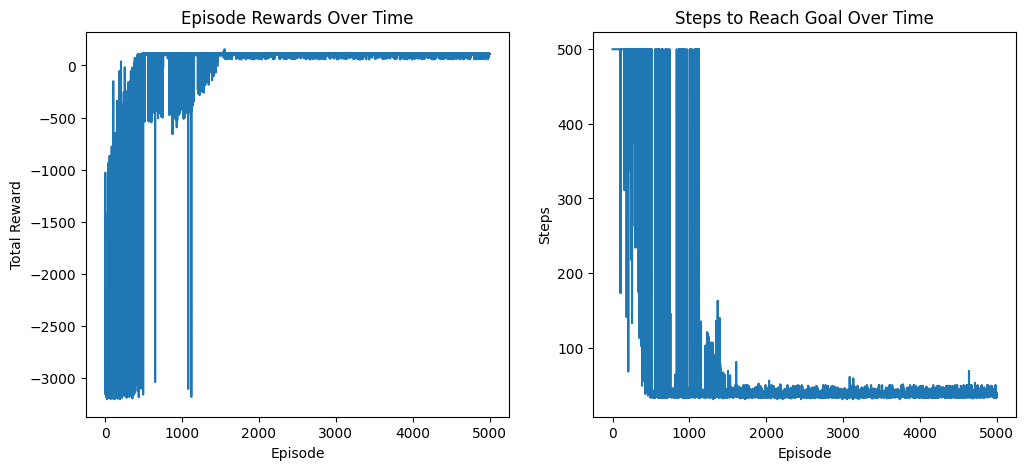

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_sarsa_model_pr1.pkl'

    # Train the agent using SARSA
    Q, sarsa_rewards_pr1, sarsa_steps_pr1 = sarsa(env, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, episodes=5000, max_steps=500)

    # Save the trained model
    #save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(sarsa_rewards_pr1, sarsa_steps_pr1)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action from the Q-table
        action = np.argmax(Q[state_key])
        children = generate_children(state, None)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break


Model loaded from map2_sarsa_model_pr1.pkl
Initial State:


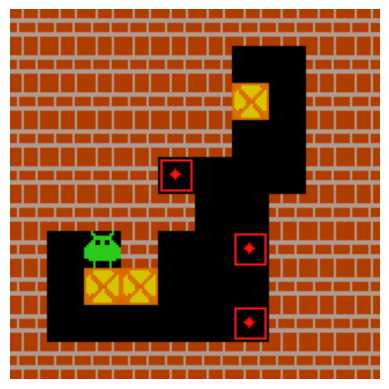

Agent Moved:


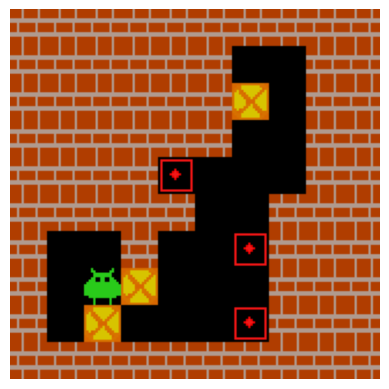

Agent Moved:


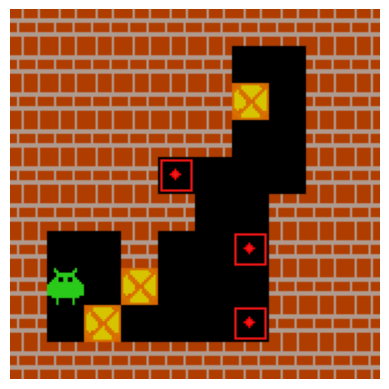

Agent Moved:


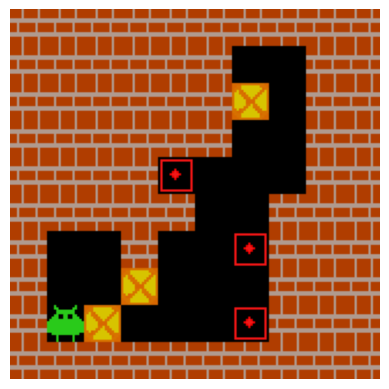

Agent Moved:


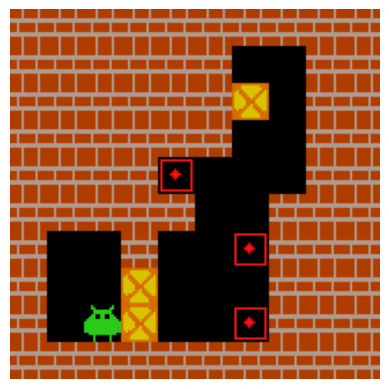

Agent Moved:


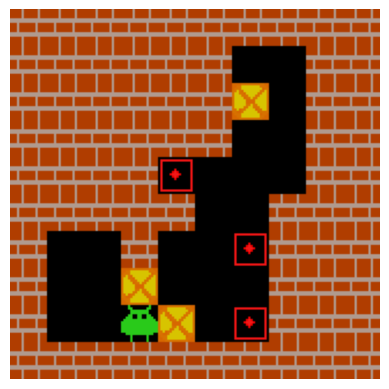

Agent Moved:


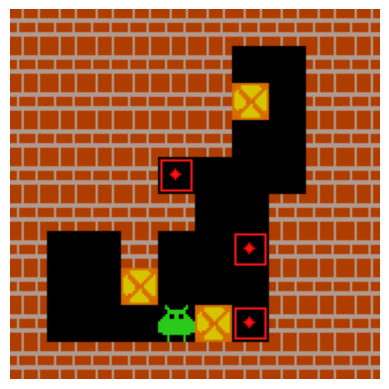

Agent Moved:


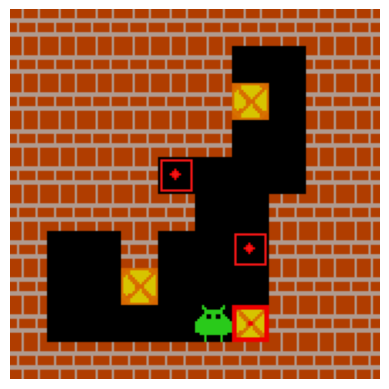

Agent Moved:


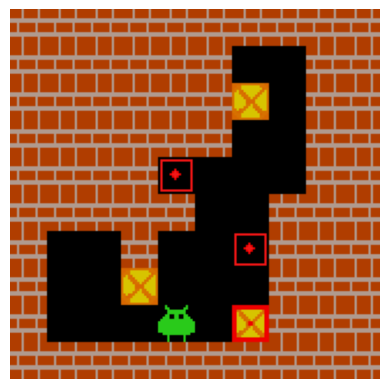

Agent Moved:


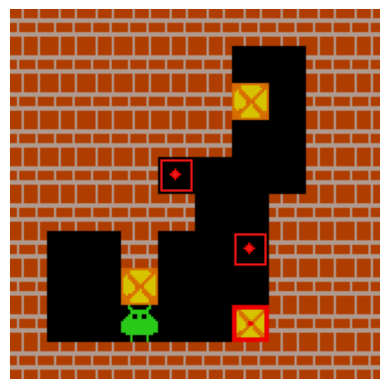

Agent Moved:


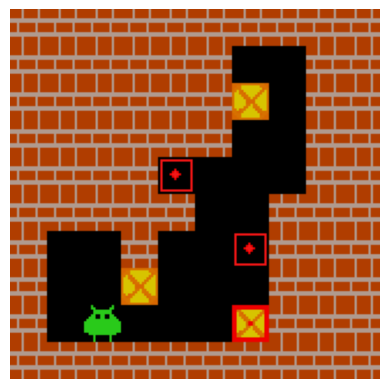

Agent Moved:


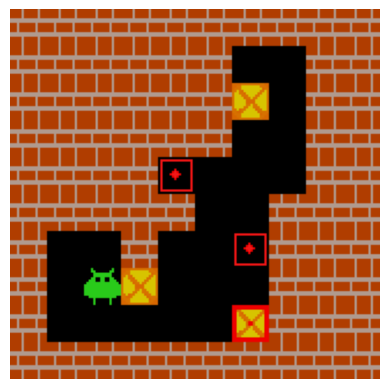

Agent Moved:


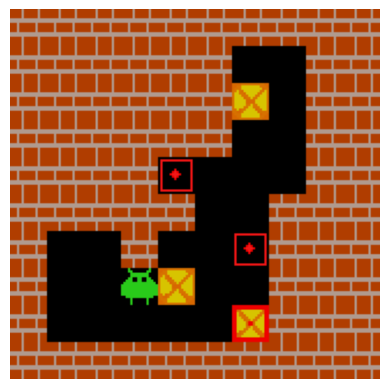

Agent Moved:


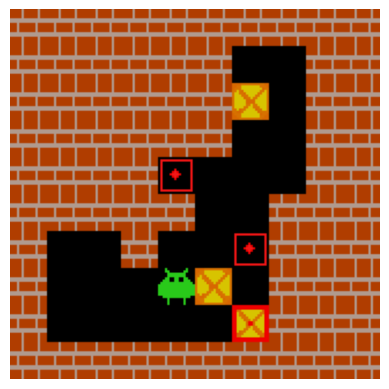

Agent Moved:


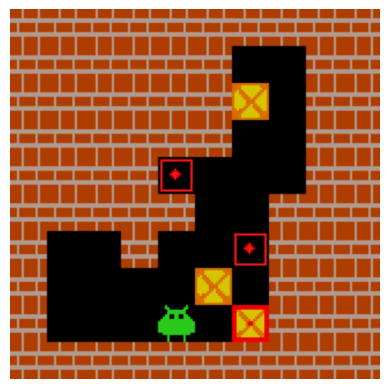

Agent Moved:


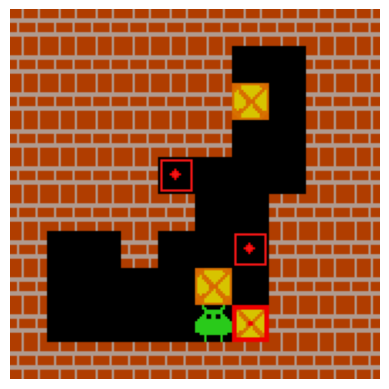

Agent Moved:


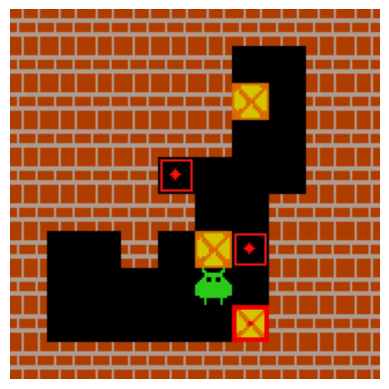

Agent Moved:


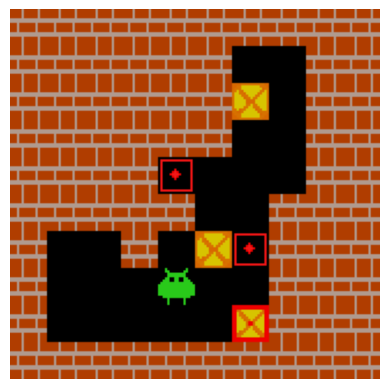

Agent Moved:


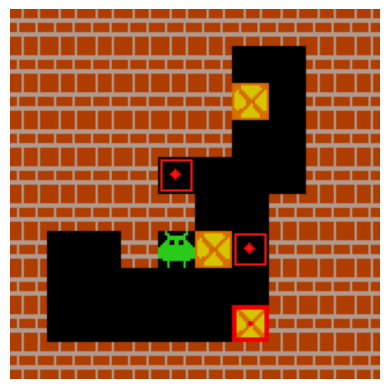

Agent Moved:


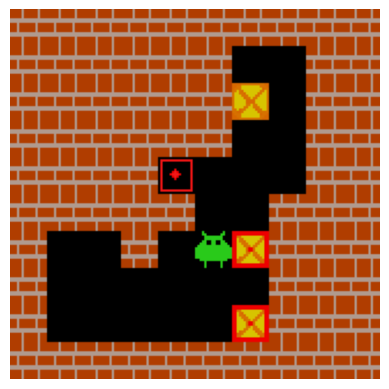

Agent Moved:


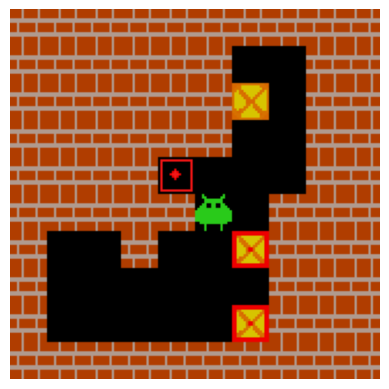

Agent Moved:


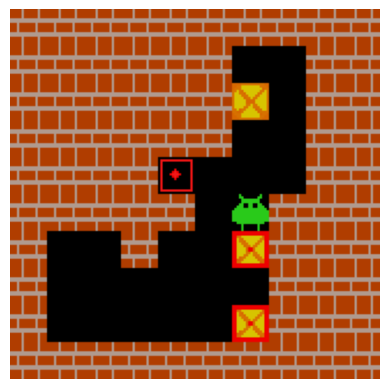

Agent Moved:


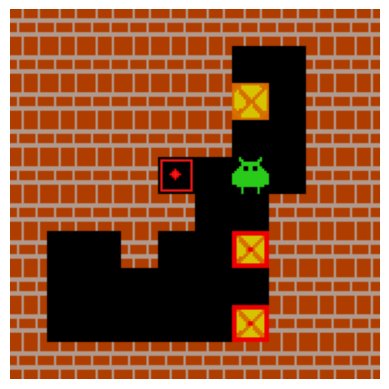

Agent Moved:


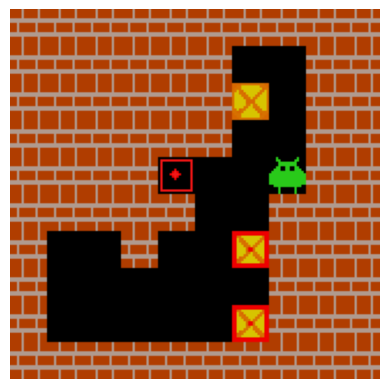

Agent Moved:


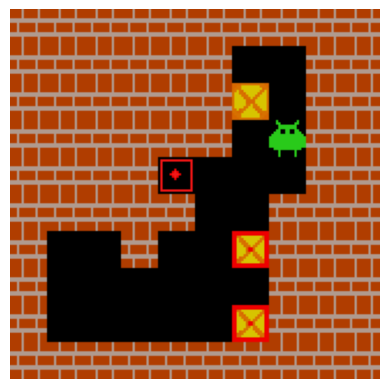

Agent Moved:


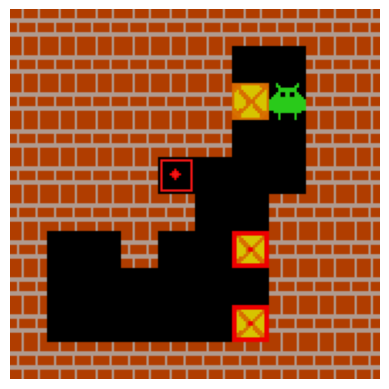

Agent Moved:


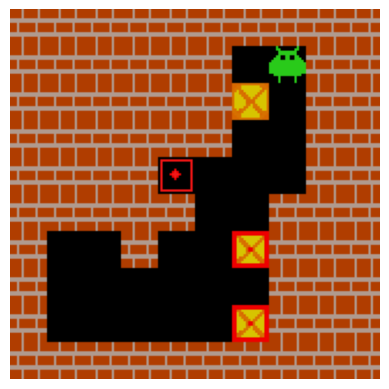

Agent Moved:


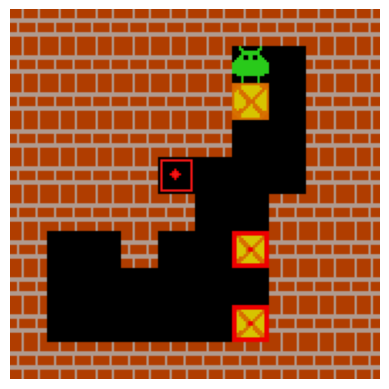

Agent Moved:


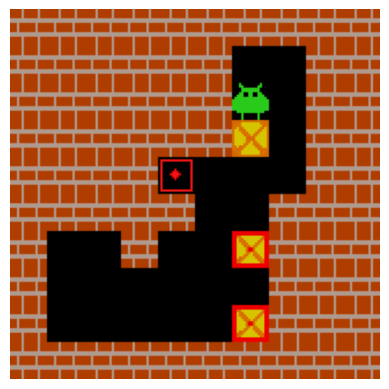

Agent Moved:


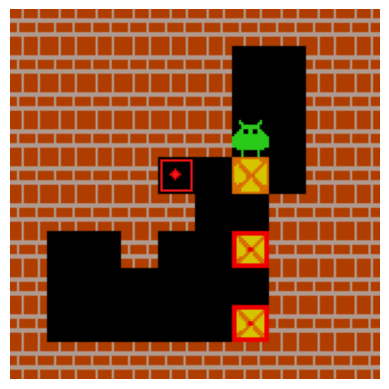

Agent Moved:


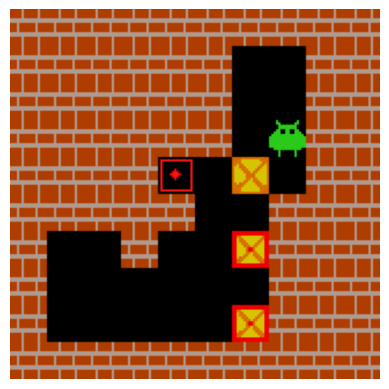

Agent Moved:


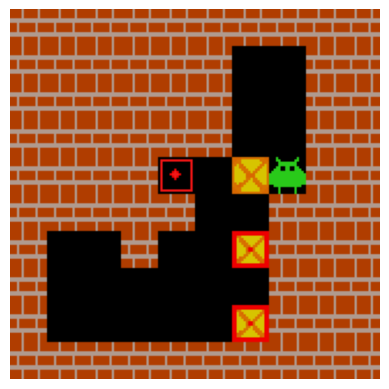

Agent Moved:


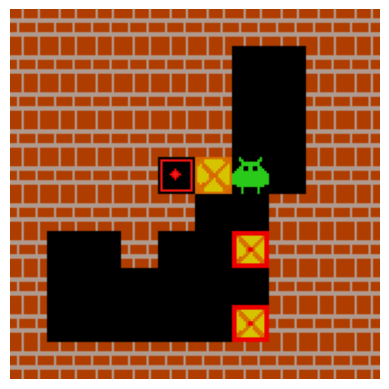

Agent Moved:


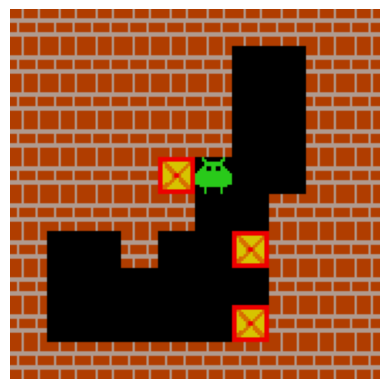

Goal Reached!


In [24]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_sarsa_model_pr1.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


Episode 0: Total Reward: -3039, Steps: 500
Episode 100: Total Reward: -757, Steps: 500
Episode 200: Total Reward: -3189, Steps: 500
Episode 300: Total Reward: -3109, Steps: 500
Episode 400: Total Reward: 58, Steps: 73
Episode 500: Total Reward: 108, Steps: 42
Episode 600: Total Reward: 92, Steps: 49
Episode 700: Total Reward: -425, Steps: 500
Episode 800: Total Reward: 106, Steps: 44
Episode 900: Total Reward: 114, Steps: 39
Episode 1000: Total Reward: 100, Steps: 46
Episode 1100: Total Reward: 100, Steps: 47
Episode 1200: Total Reward: 112, Steps: 41
Episode 1300: Total Reward: 108, Steps: 42
Episode 1400: Total Reward: 110, Steps: 43
Episode 1500: Total Reward: 112, Steps: 41
Episode 1600: Total Reward: 106, Steps: 47
Episode 1700: Total Reward: 104, Steps: 43
Episode 1800: Total Reward: 100, Steps: 47
Episode 1900: Total Reward: 108, Steps: 45
Episode 2000: Total Reward: 110, Steps: 43
Episode 2100: Total Reward: 104, Steps: 43
Episode 2200: Total Reward: 46, Steps: 59
Episode 2300:

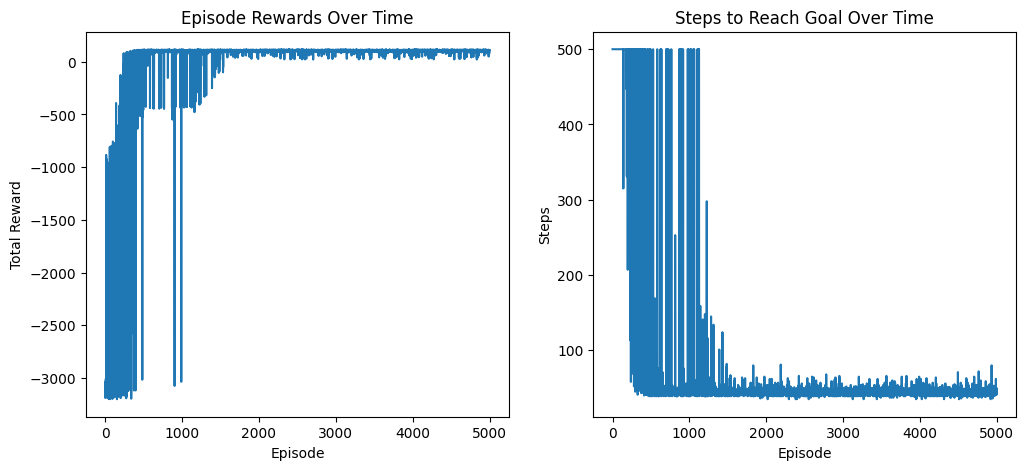

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_sarsa_model_pr2.pkl'

    # Train the agent using SARSA
    Q, sarsa_rewards_pr2, sarsa_steps_pr2 = sarsa(env, alpha=0.2, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, episodes=5000, max_steps=500)

    # Save the trained model
    #save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(sarsa_rewards_pr2, sarsa_steps_pr2)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action from the Q-table
        action = np.argmax(Q[state_key])
        children = generate_children(state, None)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break


Model loaded from map2_sarsa_model_pr2.pkl
Initial State:


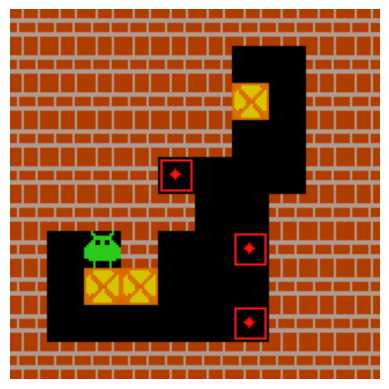

Agent Moved:


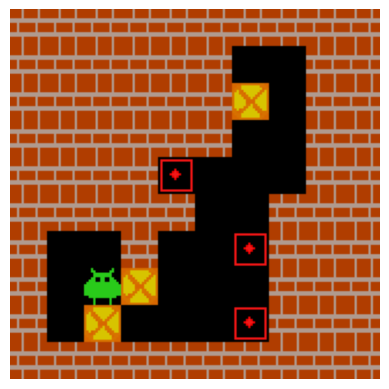

Agent Moved:


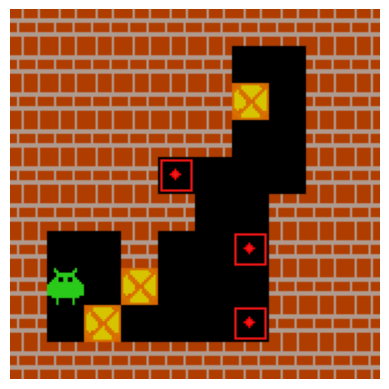

Agent Moved:


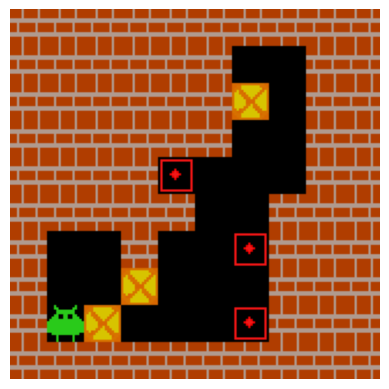

Agent Moved:


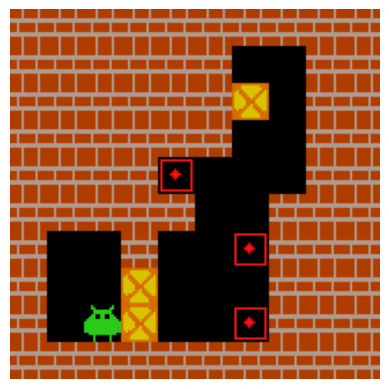

Agent Moved:


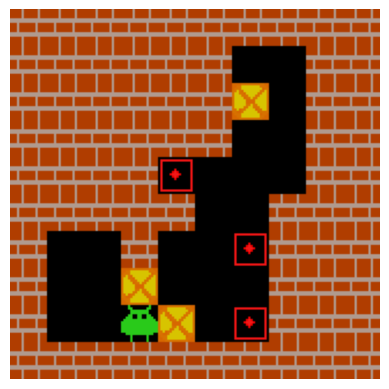

Agent Moved:


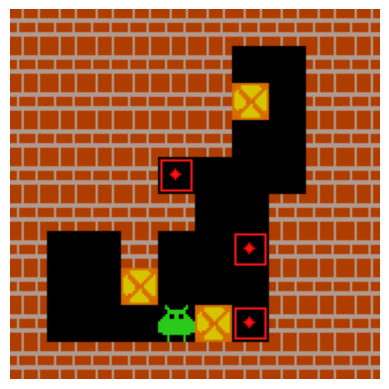

Agent Moved:


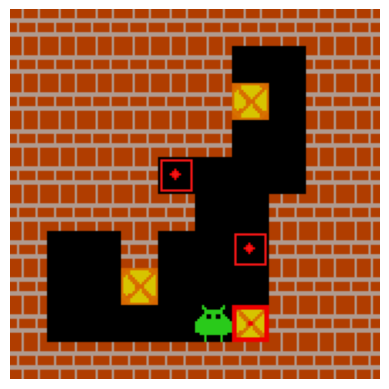

Agent Moved:


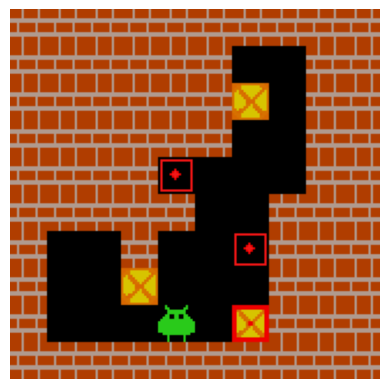

Agent Moved:


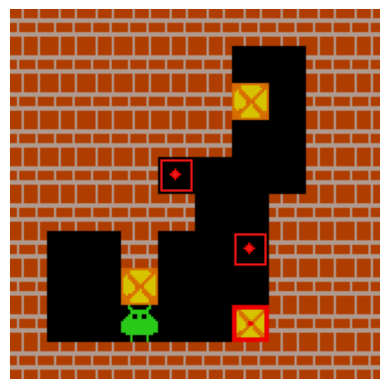

Agent Moved:


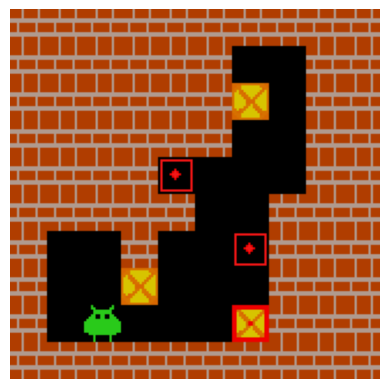

Agent Moved:


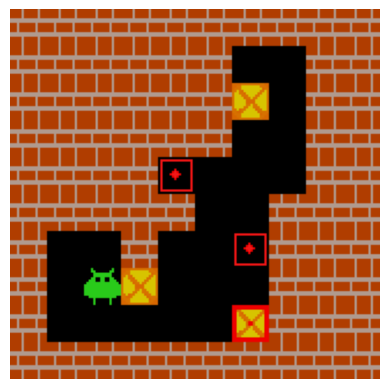

Agent Moved:


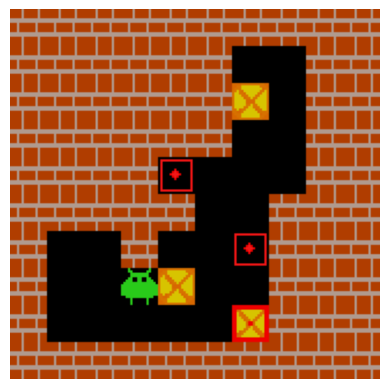

Agent Moved:


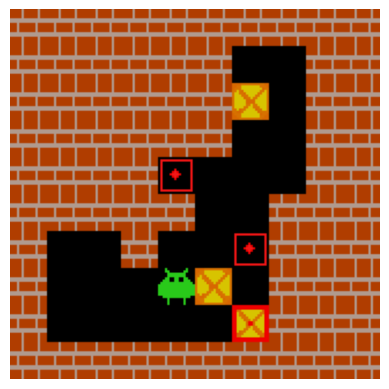

Agent Moved:


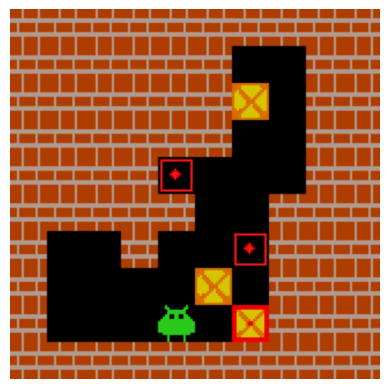

Agent Moved:


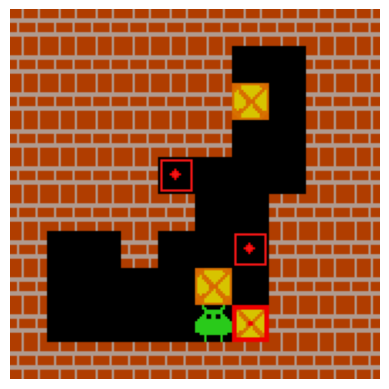

Agent Moved:


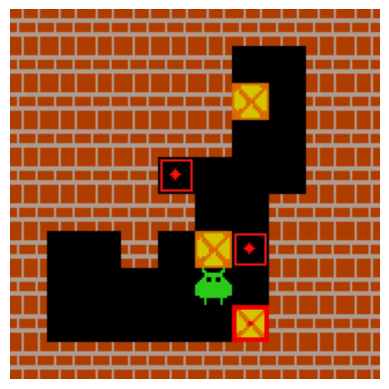

Agent Moved:


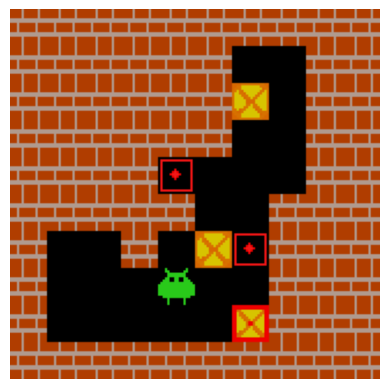

Agent Moved:


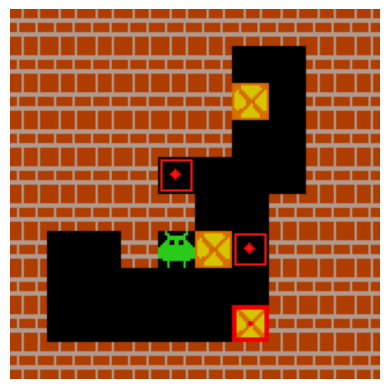

Agent Moved:


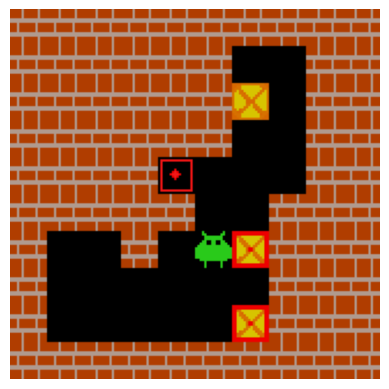

Agent Moved:


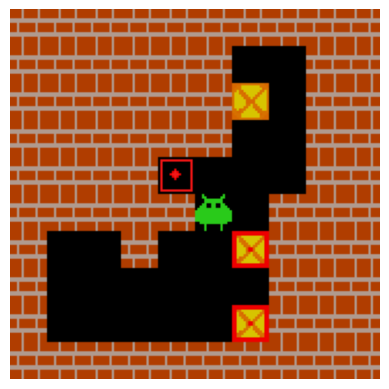

Agent Moved:


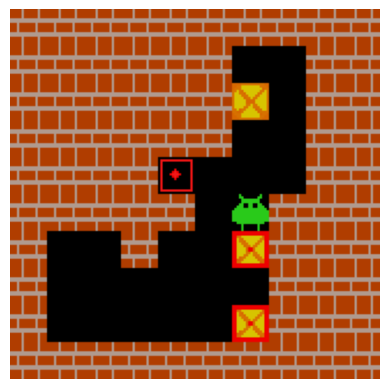

Agent Moved:


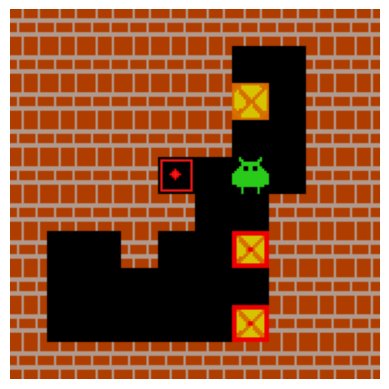

Agent Moved:


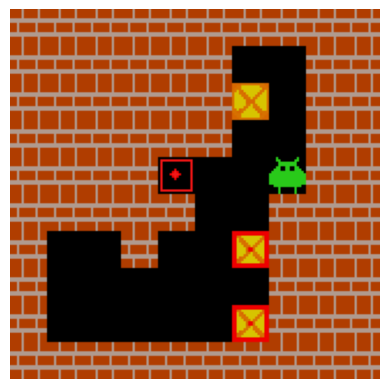

Agent Moved:


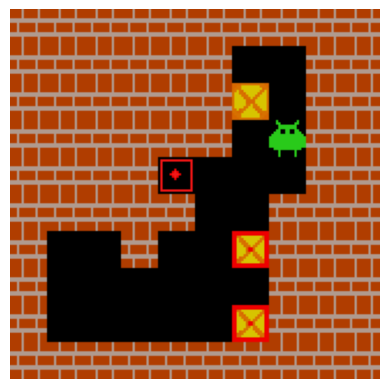

Agent Moved:


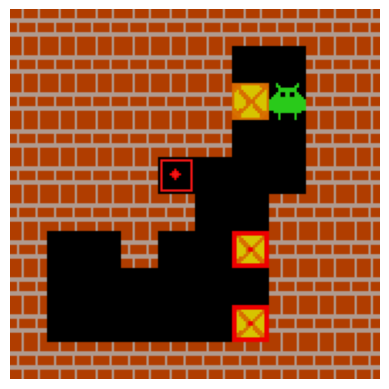

Agent Moved:


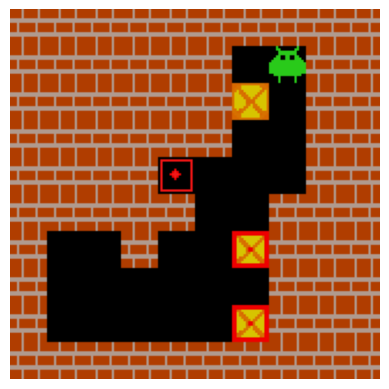

Agent Moved:


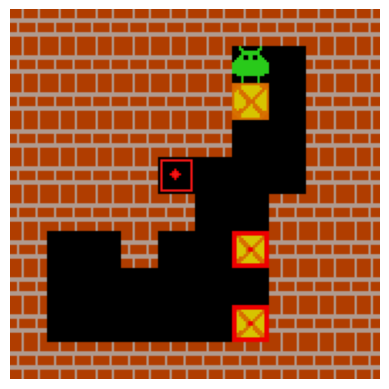

Agent Moved:


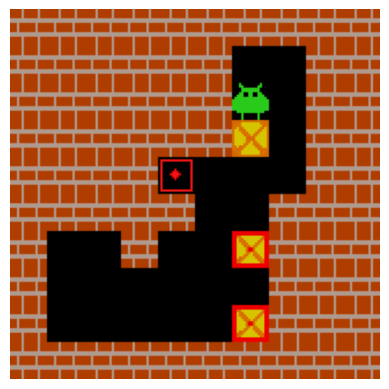

Agent Moved:


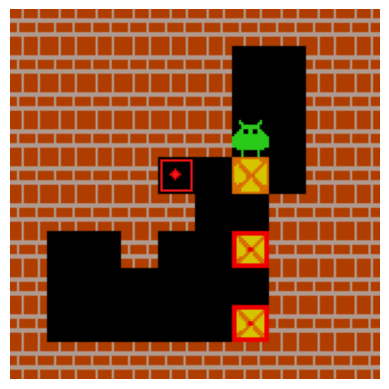

Agent Moved:


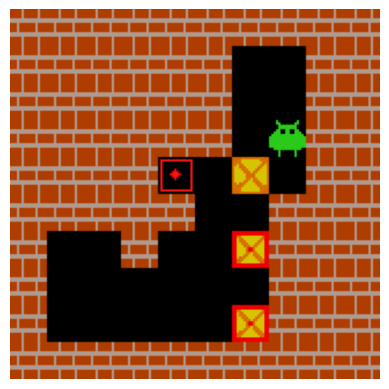

Agent Moved:


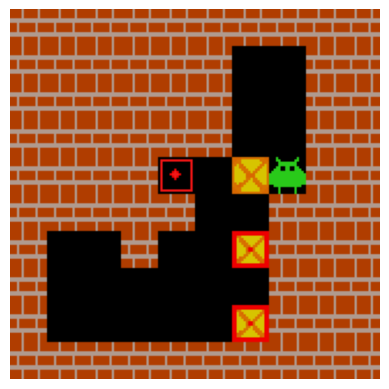

Agent Moved:


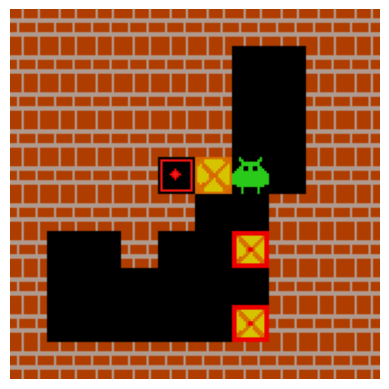

Agent Moved:


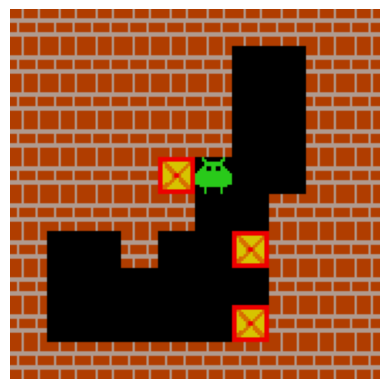

Goal Reached!


In [25]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_sarsa_model_pr2.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


Episode 0: Total Reward: -1115, Steps: 500
Episode 100: Total Reward: -3024, Steps: 500
Episode 200: Total Reward: -3082, Steps: 500
Episode 300: Total Reward: -556, Steps: 500
Episode 400: Total Reward: -3097, Steps: 500
Episode 500: Total Reward: 48, Steps: 93
Episode 600: Total Reward: -438, Steps: 500
Episode 700: Total Reward: 104, Steps: 42
Episode 800: Total Reward: 114, Steps: 36
Episode 900: Total Reward: 120, Steps: 35
Episode 1000: Total Reward: 110, Steps: 37
Episode 1100: Total Reward: 120, Steps: 35
Episode 1200: Total Reward: 108, Steps: 38
Episode 1300: Total Reward: 110, Steps: 40
Episode 1400: Total Reward: 118, Steps: 35
Episode 1500: Total Reward: 116, Steps: 35
Episode 1600: Total Reward: 116, Steps: 37
Episode 1700: Total Reward: 110, Steps: 40
Episode 1800: Total Reward: 112, Steps: 35
Episode 1900: Total Reward: 118, Steps: 35
Episode 2000: Total Reward: 112, Steps: 35
Episode 2100: Total Reward: 100, Steps: 41
Episode 2200: Total Reward: 108, Steps: 45
Episode 

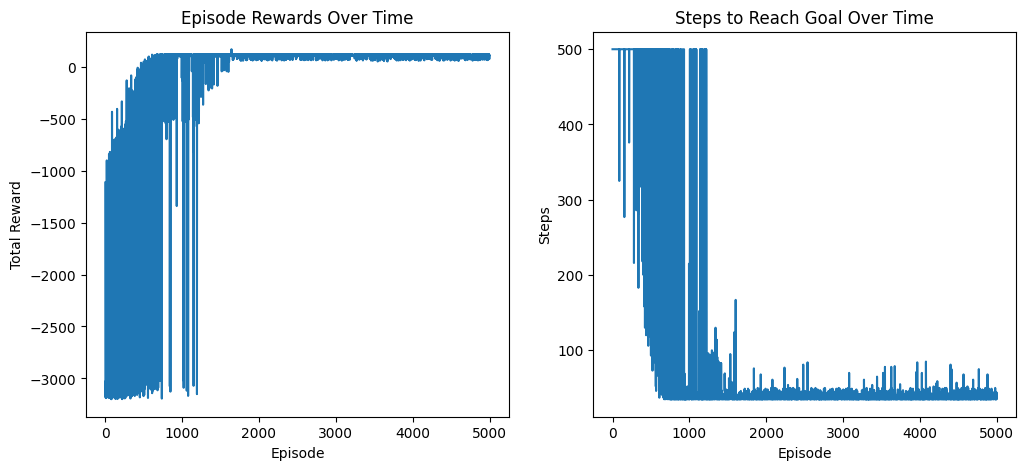

Initial State:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 5 1 0 0 3 1 1 1]
 [1 0 2 2 0 0 0 1 1 1]
 [1 0 0 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 5 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 5 0 2 0 0 0 1 1 1]
 [1 0 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 1 2 0 1 1]
 [1 1 1 1 1 1 0 0 1 1]
 [1 1 1 1 3 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 3 1 1 1]
 [1 0 0 2 0 0 0 1 1 1]
 [1 5 2 0 0 0 3 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
Agent Moved:
[[1 1 1 1

In [ ]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_sarsa_model_pr3.pkl'

    # Train the agent using SARSA
    Q, sarsa_rewards_pr3, sarsa_steps_pr3 = sarsa(env, alpha=0.05, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, episodes=5000, max_steps=500)

    # Save the trained model
    save_model(Q, filename)

    # Load the model for simulation
    Q = load_model(filename)

    # Print and plot results
    print("Final Q-values:")
    for state in list(Q.keys())[:5]:  # Show a few states' Q-values
        print(f"State: {state}, Q-values: {Q[state]}")

    # Plot rewards and steps
    plot_learning(sarsa_rewards_pr3, sarsa_steps_pr3)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")
    print(state)

    while not is_goal(state) and not is_deadlock(state):
        state_key = flatten_state(state)

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action from the Q-table
        action = np.argmax(Q[state_key])
        children = generate_children(state, None)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")
        print(state)

        if is_goal(state):
            print("Goal Reached!")
            break


Model loaded from map2_sarsa_model_pr1.pkl
Initial State:


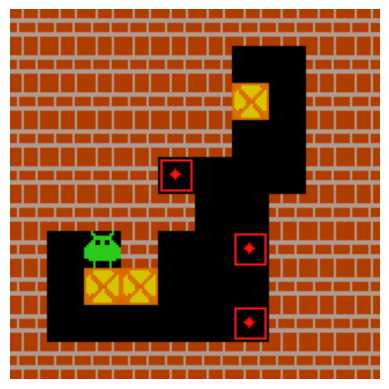

Agent Moved:


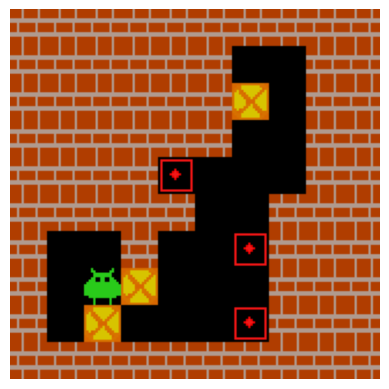

Agent Moved:


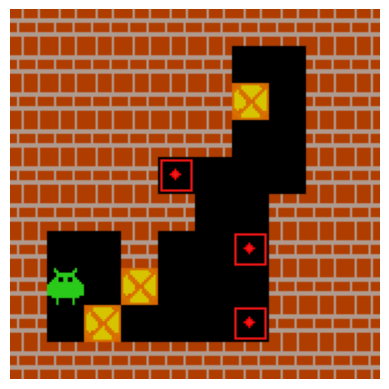

Agent Moved:


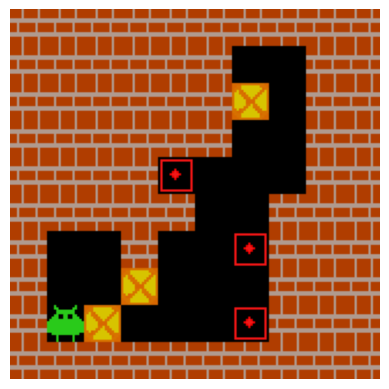

Agent Moved:


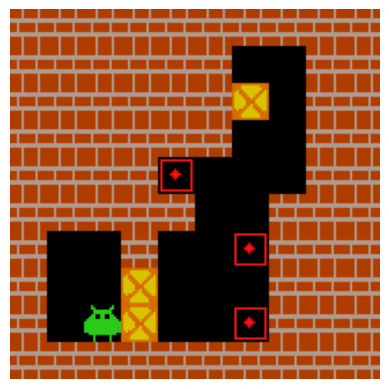

Agent Moved:


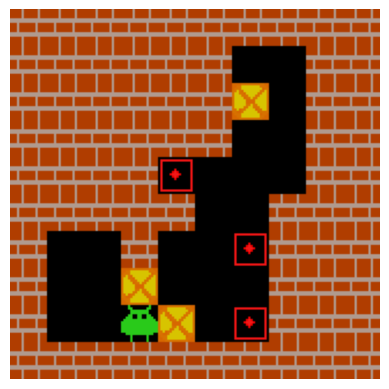

Agent Moved:


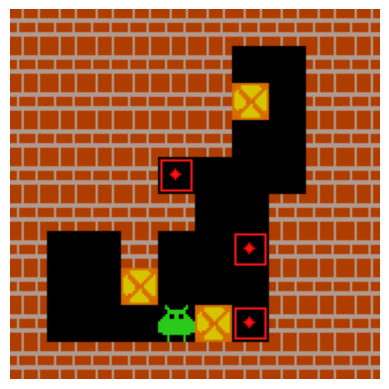

Agent Moved:


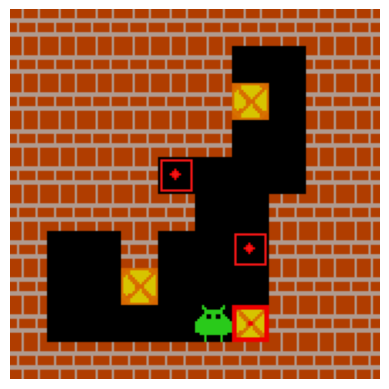

Agent Moved:


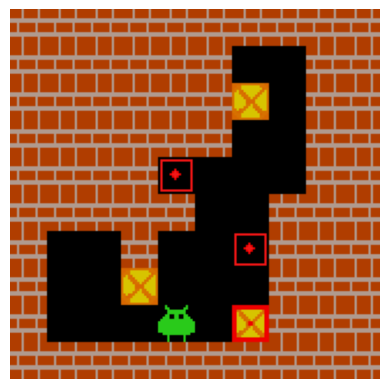

Agent Moved:


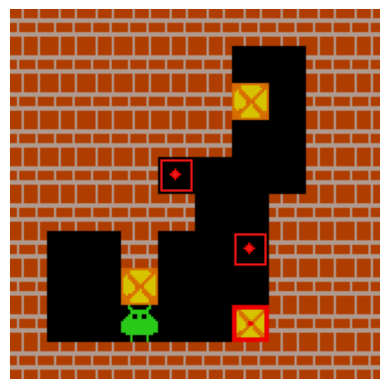

Agent Moved:


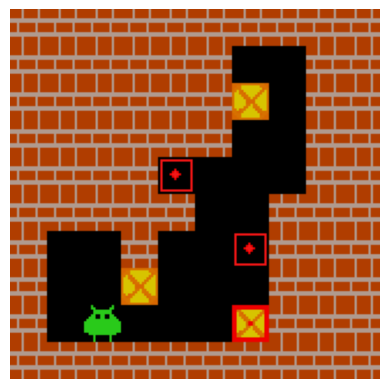

Agent Moved:


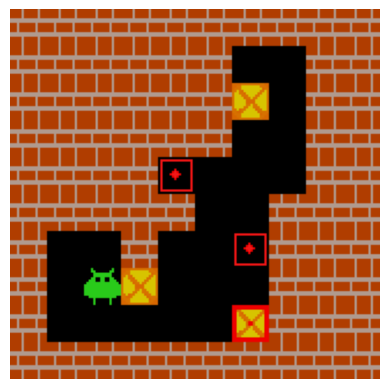

Agent Moved:


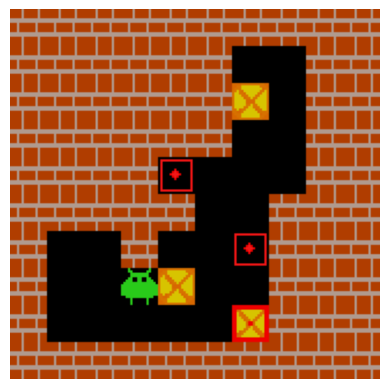

Agent Moved:


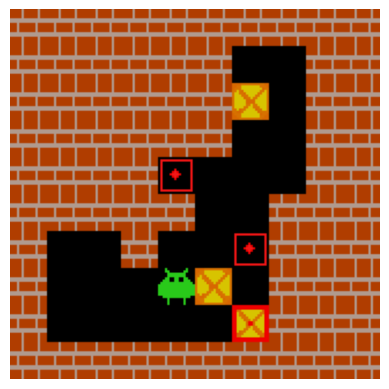

Agent Moved:


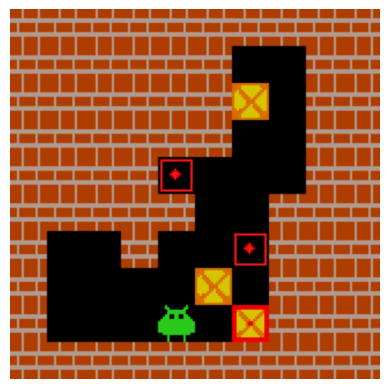

Agent Moved:


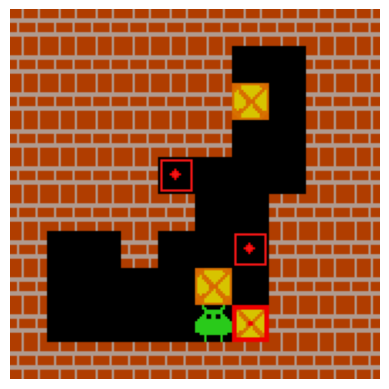

Agent Moved:


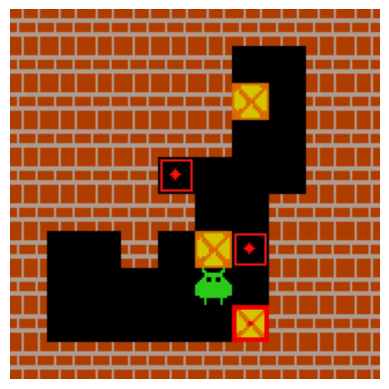

Agent Moved:


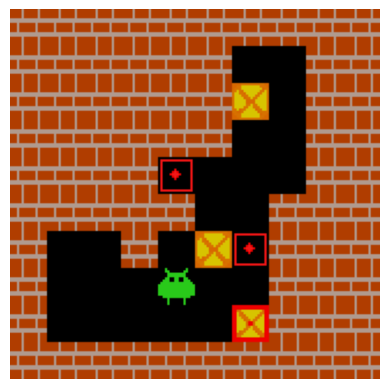

Agent Moved:


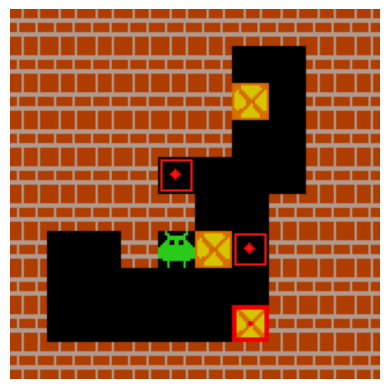

Agent Moved:


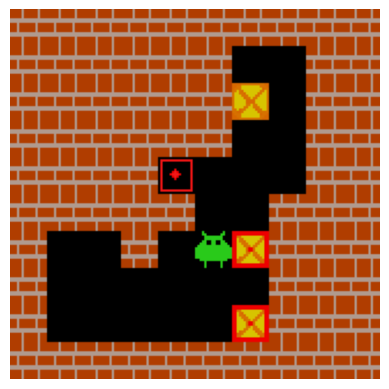

Agent Moved:


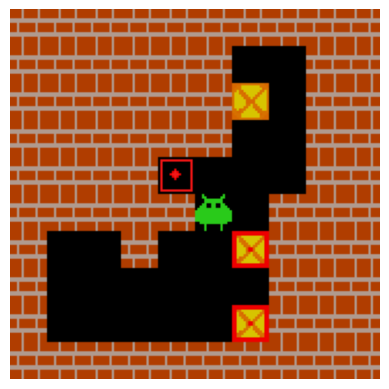

Agent Moved:


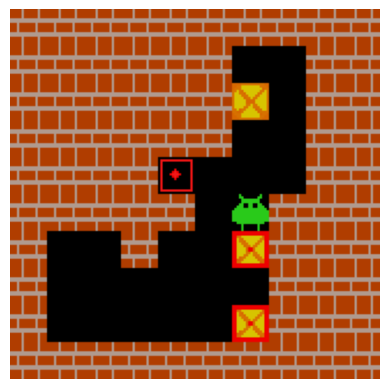

Agent Moved:


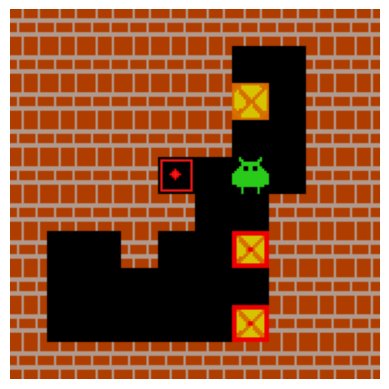

Agent Moved:


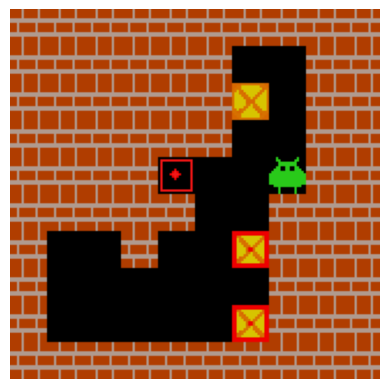

Agent Moved:


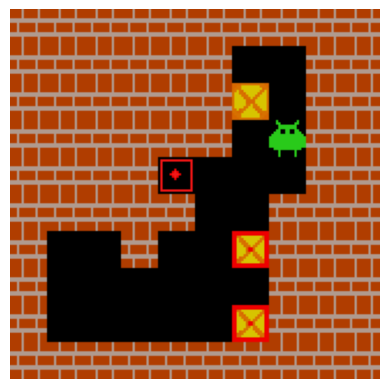

Agent Moved:


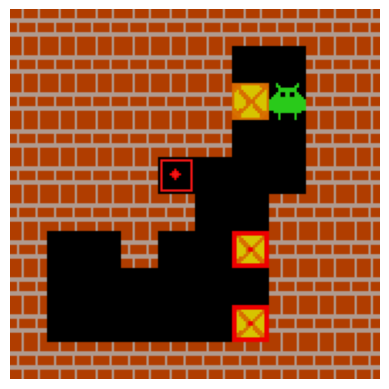

Agent Moved:


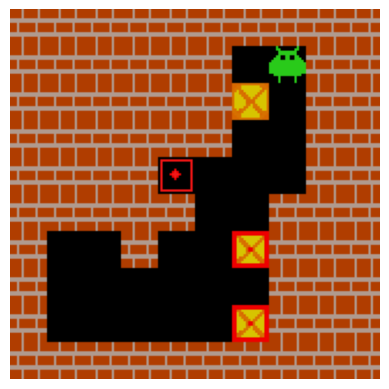

Agent Moved:


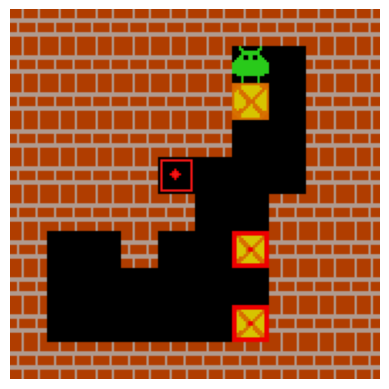

Agent Moved:


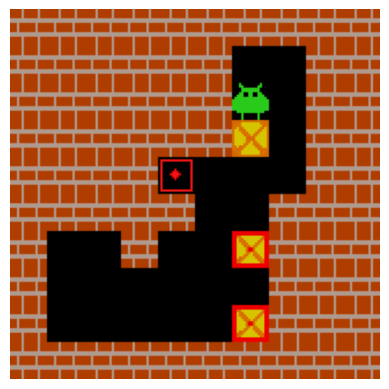

Agent Moved:


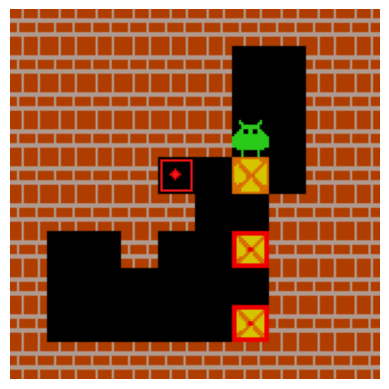

Agent Moved:


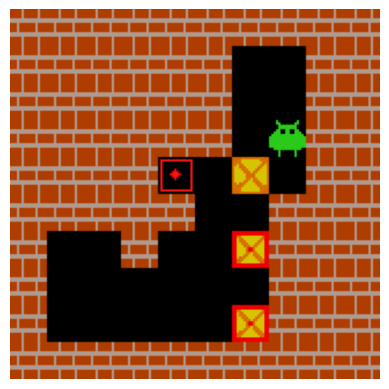

Agent Moved:


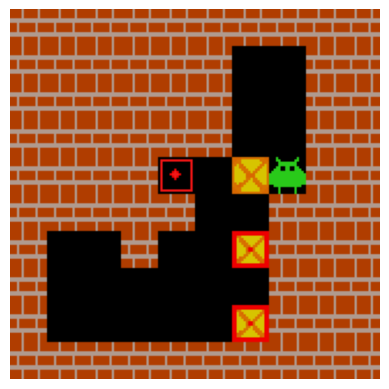

Agent Moved:


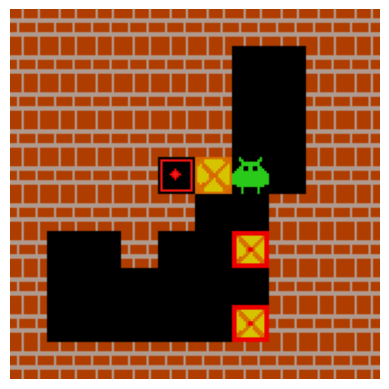

Agent Moved:


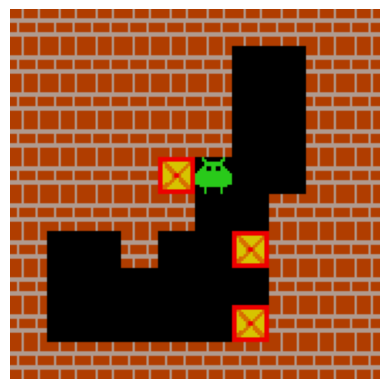

Goal Reached!


In [26]:
# Main function
if __name__ == "__main__":
    # Initialize environment
    env = init()

    filename = 'map2_sarsa_model_pr1.pkl'

    # Load the model for simulation
    Q = load_model(filename)

    # Simulate agent's gameplay using learned Q-values
    state = np.copy(env)
    previous_state = None
    print("Initial State:")

    display_env(state)  # Display initial state

    while not is_goal(state):
        state_key = tuple(state.flatten())  # Use tuple for hashable state keys

        if state_key not in Q:
            print("Unknown state encountered, terminating.")
            break

        # Choose the best action
        action = np.argmax(Q[state_key])
        children = generate_children(state, previous_state)

        # Apply the best action
        next_state, _ = children[action]
        state = next_state
        print("Agent Moved:")

        display_env(state)  # Display updated state after each move

        if is_goal(state):
            print("Goal Reached!")
            break


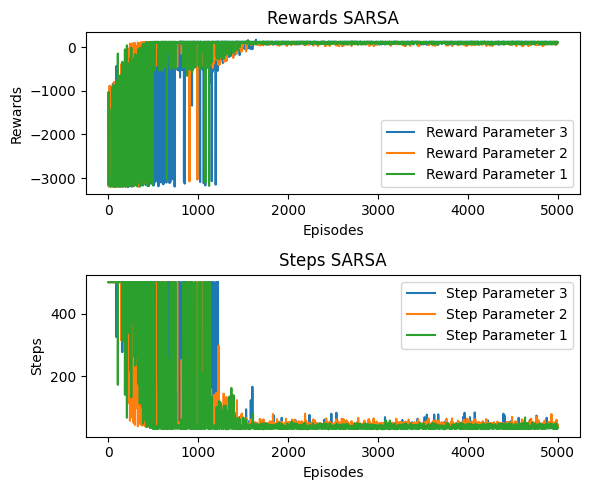

In [ ]:
model = 'SARSA'
plot_pr(model, sarsa_rewards_pr3,sarsa_rewards_pr2, sarsa_rewards_pr1 , sarsa_steps_pr3, sarsa_steps_pr2, sarsa_steps_pr1)

**Evaluation**

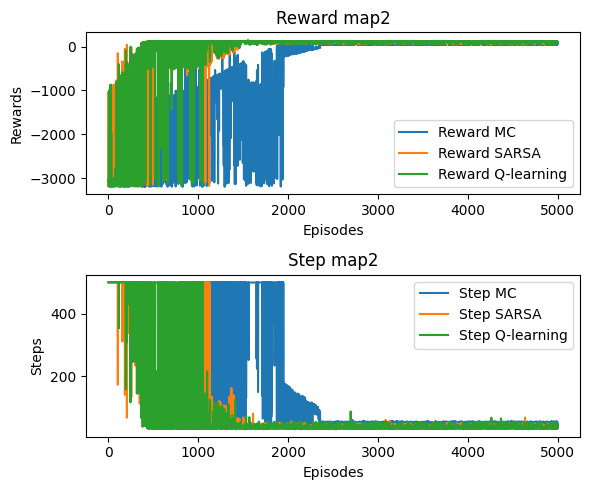

In [ ]:
map = 'map2'
plot_map(map, mc_rewards_pr1, sarsa_rewards_pr1,ql_rewards_pr1, mc_steps_pr1, sarsa_steps_pr1, ql_steps_pr1)
